># **PROBLEM STATEMENT**

>---



> ##  **DOMAIN**: MACHINE TRANSLATION.


---




> ## **CONTEXT:**
Machine Translation is the automated translation of source material into another language without human intervention. The database comes
from ACL2014 Ninth workshop on Statistical Machine Translation. This workshop mainly focusses on language translation between European
language pairs. The idea behind the workshop is to provide the ability for two parties to communicate and exchange the ideas from different
countries.


---



> ## **DATA DESCRIPTION:**
The database is basically sentences in German/English of various events. Three datasets are obtained from Statistical Machine Translation
workshop. Either the dataset can be downloaded from the link or can be used from the shared files. Three datasets are,

*   Europarl v7
*   Common Crawl corpus
*   News Commentary

Link to download the dataset: https://statmt.org/wmt14/translation-task.html


---



> ## **PROJECT OBJECTIVE:**
Design a Machine Translation model that can be used to translate sentences from German language to English language or vice-versa.


---



> ## **PROJECT TASK:**


---




>> ### **1. Milestone 1:**

---



>>> **Input:** Context and Dataset

---



>>> **Process:**

---



>>>> ####  Exploring Datasets.

In [ ]:
!pip install wordcloud

In [ ]:
import re
import string
import pickle
import random
import tarfile
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, Embedding, LSTM, TimeDistributed, Input, SimpleRNN, Bidirectional, Dense, RepeatVector, Concatenate, Attention, Dot, Activation
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Extracting the datasets and viewing the files.

In [ ]:
# Paths to the .tgz files
base_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/'
europarl_tgz = os.path.join(base_path, 'training-parallel-europarl-v7.tgz')
common_crawl_tgz = os.path.join(base_path, 'training-parallel-commoncrawl.tgz')
news_commentary_tgz = os.path.join(base_path, 'training-parallel-nc-v9.tgz')

# Extract function
def extract_tgz(tgz_path, extract_to):
    with tarfile.open(tgz_path, 'r:gz') as tar:
        tar.extractall(path=extract_to)

# Extract all datasets directly to the base_path
extract_tgz(europarl_tgz, base_path)
extract_tgz(common_crawl_tgz, base_path)
extract_tgz(news_commentary_tgz, base_path)

In [ ]:
base_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/'

# Path to the training directory
training_dir = os.path.join(base_path, 'training')

# Print all files inside the training directory
print("Files in training directory:")
for file in os.listdir(training_dir):
    print(file)

Files in training directory:
commoncrawl.es-en.es
commoncrawl.es-en.annotation
commoncrawl.es-en.en
commoncrawl.fr-en.fr
commoncrawl.fr-en.annotation
commoncrawl.fr-en.en
commoncrawl.de-en.de
commoncrawl.de-en.annotation
commoncrawl.de-en.en
commoncrawl.ru-en.en
commoncrawl.ru-en.annotation
commoncrawl.cs-en.cs
commoncrawl.cs-en.en
commoncrawl.cs-en.annotation
commoncrawl.ru-en.ru
europarl-v7.cs-en.cs
europarl-v7.cs-en.en
europarl-v7.de-en.de
europarl-v7.de-en.en
europarl-v7.es-en.en
europarl-v7.es-en.es
europarl-v7.fr-en.en
europarl-v7.fr-en.fr
news-commentary-v9.ru-en.en
news-commentary-v9.fr-en.en
news-commentary-v9.ru-en.ru
news-commentary-v9.cs-en.cs
news-commentary-v9.de-en.en
news-commentary-v9.cs-en.en
news-commentary-v9.de-en.de
news-commentary-v9.fr-en.fr


In [ ]:
# Import sentences from WMT News Commentary v9
Path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/' # Add a trailing slash to the path
try:
    with open(Path+"news-commentary-v9.de-en.de", "r", encoding="utf-8") as german_file:
        news_german_sentences = german_file.readlines()
    with open(Path+"news-commentary-v9.de-en.en", "r", encoding="utf-8") as english_file:
        news_english_sentences = english_file.readlines()
except FileNotFoundError:
      print("Error: WMT News Commentary files not found!")
      news_german_sentences = [] # Assign an empty list to avoid NameError
      news_english_sentences = [] # Assign an empty list to avoid NameError
else:
      print("Successfully read WMT News Commentary sentences.")

# Import sentences from Europarl v7
try:
    with open(Path+"europarl-v7.de-en.de", "r", encoding="utf-8") as german_file:
        euro_german_sentences = german_file.readlines()
    with open(Path+"europarl-v7.de-en.en", "r", encoding="utf-8") as english_file:
        euro_english_sentences = english_file.readlines()
except FileNotFoundError:
    print("Error: Europarl v7 files not found!")
else:
    print("Successfully read Europarl v7 sentences.")

# Import sentences from Common Crawl
try:
    with open(Path+"commoncrawl.de-en.de", "r", encoding="utf-8") as german_file:
        common_german_sentences = german_file.readlines()
    with open(Path+"commoncrawl.de-en.en", "r", encoding="utf-8") as english_file:
        common_english_sentences = english_file.readlines()
except FileNotFoundError:
    print("Error: Common Crawl files not found!")
else:
    print("Successfully read Common Crawl sentences.")

print("Number of German WMT News Commentary sentences:", len(news_german_sentences))
print("Number of English WMT News Commentary sentences:", len(news_english_sentences))
print("")
print("Number of German Europarl v7 sentences:", len(euro_german_sentences))
print("Number of English Europarl v7 sentences:", len(euro_english_sentences))
print("")
print("Number of German Common Crawl sentences:", len(common_german_sentences))
print("Number of English Common Crawl sentences:", len(common_english_sentences))

Successfully read WMT News Commentary sentences.
Successfully read Europarl v7 sentences.
Successfully read Common Crawl sentences.
Number of German WMT News Commentary sentences: 201854
Number of English WMT News Commentary sentences: 201995

Number of German Europarl v7 sentences: 1920209
Number of English Europarl v7 sentences: 1920209

Number of German Common Crawl sentences: 2399123
Number of English Common Crawl sentences: 2399123


##### Viewing the content of relevant files

In [ ]:
def display_first_1000_characters(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        first_1000_characters = content[:1000]
        print("First 1000 characters:")
        print(first_1000_characters)
        print("\n")

In [ ]:
# Path to the file
file_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/europarl-v7.de-en.de'

# Display the first 1000 characters
display_first_1000_characters(file_path)

First 1000 characters:
Wiederaufnahme der Sitzungsperiode
Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.
Wie Sie feststellen konnten, ist der gefürchtete "Millenium-Bug " nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.
Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen.
Heute möchte ich Sie bitten - das ist auch der Wunsch einiger Kolleginnen und Kollegen -, allen Opfern der Stürme, insbesondere in den verschiedenen Ländern der Europäischen Union, in einer Schweigeminute zu gedenken.
Ich bitte Sie, sich zu einer Schweigeminute zu erheben.
(Das Parlament erhebt sich zu einer Schweigeminute.)
Frau Präsidentin, zur Geschäftsordnung.
Wie Sie sicher aus der Presse und dem Fernsehen wissen, gab

In [ ]:
# Path to the file
file_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/europarl-v7.de-en.en'

# Display the first 1000 characters
display_first_1000_characters(file_path)

First 1000 characters:
Resumption of the session
I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.
You have requested a debate on this subject in the course of the next few days, during this part-session.
In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.
Please rise, then, for this minute' s silence.
(The House rose and observed a minute' s silence)
Madam President, on a point of order.
You will be aware from the press and television that there have been a number

In [ ]:
# Path to the file
file_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/commoncrawl.de-en.de'

# Display the first 1000 characters
display_first_1000_characters(file_path)

First 1000 characters:
iron cement ist eine gebrauchs-fertige Paste, die mit einem Spachtel oder den Fingern als Hohlkehle in die Formecken (Winkel) der Stahlguss -Kokille aufgetragen wird.
Nach der Aushärtung schützt iron cement die Kokille gegen den heissen, abrasiven Stahlguss .
feuerfester Reparaturkitt für Feuerungsanlagen, Öfen, offene Feuerstellen etc.
Der Bau und die Reparatur der Autostraßen...
die Mitteilungen sollen den geschäftlichen kommerziellen Charakter tragen.
der Vertrieb Ihrer Waren und Dienstleistungen durch das Postfach-System WIRD NICHT ZUGELASSEN.
die Werbeversande (Spam) und andere unkorrekte Informationen werden gelöscht.
ACDSee 9 Photo Manager Organize your photos. Share your world.
No matter what kind of photos you take - of friends and family or artistic shots as a hobby - you need photo software that organizes your shots AND allows you to view, fix, and share them quickly and easily.
ACDSee 9 makes organizing your photos exactly that: Quick and easy, so you

In [ ]:
# Path to the file
file_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/commoncrawl.de-en.en'

# Display the first 1000 characters
display_first_1000_characters(file_path)

First 1000 characters:
iron cement is a ready for use paste which is laid as a fillet by putty knife or finger in the mould edges (corners) of the steel ingot mould.
iron cement protects the ingot against the hot, abrasive steel casting process.
a fire restant repair cement for fire places, ovens, open fireplaces etc.
Construction and repair of highways and...
An announcement must be commercial character.
Goods and services advancement through the P.O.Box system is NOT ALLOWED.
Deliveries (spam) and other improper information deleted.
Translator Internet is a Toolbar for MS Internet Explorer.
It allows you to translate in real time any web pasge from one language to another.
You only have to select languages and TI does all the work for you! Automatic dictionary updates....
This software is written in order to increase your English keyboard typing speed, through teaching the basics of how to put your hand on to the keyboard and give some training examples.
Each lesson teaches some extr

In [ ]:
# Path to the file
file_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/news-commentary-v9.de-en.de'

# Display the first 1000 characters
display_first_1000_characters(file_path)

First 1000 characters:
Steigt Gold auf 10.000 Dollar?
SAN FRANCISCO – Es war noch nie leicht, ein rationales Gespräch über den Wert von Gold zu führen.
In letzter Zeit allerdings ist dies schwieriger denn je, ist doch der Goldpreis im letzten Jahrzehnt um über 300 Prozent angestiegen.
Erst letzten Dezember verfassten meine Kollegen Martin Feldstein und Nouriel Roubini Kommentare, in denen sie mutig die vorherrschende optimistische Marktstimmung hinterfragten und sehr überlegt auf die Risiken des Goldes  hinwiesen.
Und es kam, wie es kommen musste.
Seit der Veröffentlichung ihrer Artikel ist der Goldpreis noch weiter gestiegen.
Jüngst erreichte er sogar ein Rekordhoch von 1.300 Dollar.
Im letzten Dezember argumentierten die Goldbugs, dass der Preis zweifellos in Richtung 2.000 Dollar gehen würde.
Beflügelt aufgrund des anhaltenden Aufwärtstrends, meint man nun mancherorts, dass Gold sogar noch höher steigen könnte.
Ein erfolgreicher Gold-Investor erklärte mir vor kurzem, dass die Aktien

In [ ]:
# Path to the file
file_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/news-commentary-v9.de-en.en'

# Display the first 1000 characters
display_first_1000_characters(file_path)

First 1000 characters:
$10,000 Gold?
SAN FRANCISCO – It has never been easy to have a rational conversation about the value of gold.
Lately, with gold prices up more than 300% over the last decade, it is harder than ever.
Just last December, fellow economists Martin Feldstein and Nouriel Roubini each penned op-eds bravely questioning bullish market sentiment, sensibly pointing out gold’s risks.
Wouldn’t you know it?
Since their articles appeared, the price of gold has moved up still further.
Gold prices even hit a record-high $1,300 recently.
Last December, many gold bugs were arguing that the price was inevitably headed for $2,000.
Now, emboldened by continuing appreciation, some are suggesting that gold could be headed even higher than that.
One successful gold investor recently explained to me that stock prices languished for a more than a decade before the Dow Jones index crossed the 1,000 mark in the early 1980’s.
Since then, the index has climbed above 10,000.
Now that gold has c

>>>> #### **Step 1:** Import and merge all the three datasets.

---



In [ ]:
training_dir = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/'

# Load the datasets into pandas DataFrames
europarl_de = os.path.join(training_dir, 'europarl-v7.de-en.de')
europarl_en = os.path.join(training_dir, 'europarl-v7.de-en.en')
commoncrawl_de = os.path.join(training_dir, 'commoncrawl.de-en.de')
commoncrawl_en = os.path.join(training_dir, 'commoncrawl.de-en.en')
newscommentary_de = os.path.join(training_dir, 'news-commentary-v9.de-en.de')
newscommentary_en = os.path.join(training_dir, 'news-commentary-v9.de-en.en')

def load_dataset(de_path, en_path):
    with open(de_path, 'r', encoding='utf-8') as de_file, open(en_path, 'r', encoding='utf-8') as en_file:
        de_sentences = de_file.readlines()
        en_sentences = en_file.readlines()

    # Check if lengths match
    if len(de_sentences) != len(en_sentences):
        print(f"Length mismatch: {de_path} ({len(de_sentences)}) and {en_path} ({len(en_sentences)})")
        # Truncate to the shorter length
        min_length = min(len(de_sentences), len(en_sentences))
        de_sentences = de_sentences[:min_length]
        en_sentences = en_sentences[:min_length]

    return pd.DataFrame({'German': de_sentences, 'English': en_sentences})

# Load datasets
europarl = load_dataset(europarl_de, europarl_en)
commoncrawl = load_dataset(commoncrawl_de, commoncrawl_en)
newscommentary = load_dataset(newscommentary_de, newscommentary_en)

Length mismatch: /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/news-commentary-v9.de-en.de (201854) and /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/news-commentary-v9.de-en.en (201995)


In [ ]:
# Print the first few rows of each dataset
europarl.head()

,German,English
0,Wiederaufnahme der Sitzungsperiode\n,Resumption of the session\n
1,"Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.\n","I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.\n"
2,"Wie Sie feststellen konnten, ist der gefürchtete ""Millenium-Bug "" nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.\n","Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.\n"
3,Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen.\n,"You have requested a debate on this subject in the course of the next few days, during this part-session.\n"
4,"Heute möchte ich Sie bitten - das ist auch der Wunsch einiger Kolleginnen und Kollegen -, allen Opfern der Stürme, insbesondere in den verschiedenen Ländern der Europäischen Union, in einer Schweigeminute zu gedenken.\n","In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.\n"


In [ ]:
commoncrawl.head()

,German,English
0,"iron cement ist eine gebrauchs-fertige Paste, die mit einem Spachtel oder den Fingern als Hohlkehle in die Formecken (Winkel) der Stahlguss -Kokille aufgetragen wird.\n",iron cement is a ready for use paste which is laid as a fillet by putty knife or finger in the mould edges (corners) of the steel ingot mould.\n
1,"Nach der Aushärtung schützt iron cement die Kokille gegen den heissen, abrasiven Stahlguss .\n","iron cement protects the ingot against the hot, abrasive steel casting process.\n"
2,"feuerfester Reparaturkitt für Feuerungsanlagen, Öfen, offene Feuerstellen etc.\n","a fire restant repair cement for fire places, ovens, open fireplaces etc.\n"
3,Der Bau und die Reparatur der Autostraßen...\n,Construction and repair of highways and...\n
4,die Mitteilungen sollen den geschäftlichen kommerziellen Charakter tragen.\n,An announcement must be commercial character.\n


In [ ]:
newscommentary.head()

,German,English
0,Steigt Gold auf 10.000 Dollar?\n,"$10,000 Gold?\n"
1,"SAN FRANCISCO – Es war noch nie leicht, ein rationales Gespräch über den Wert von Gold zu führen.\n",SAN FRANCISCO – It has never been easy to have a rational conversation about the value of gold.\n
2,"In letzter Zeit allerdings ist dies schwieriger denn je, ist doch der Goldpreis im letzten Jahrzehnt um über 300 Prozent angestiegen.\n","Lately, with gold prices up more than 300% over the last decade, it is harder than ever.\n"
3,"Erst letzten Dezember verfassten meine Kollegen Martin Feldstein und Nouriel Roubini Kommentare, in denen sie mutig die vorherrschende optimistische Marktstimmung hinterfragten und sehr überlegt auf die Risiken des Goldes hinwiesen.\n","Just last December, fellow economists Martin Feldstein and Nouriel Roubini each penned op-eds bravely questioning bullish market sentiment, sensibly pointing out gold’s risks.\n"
4,"Und es kam, wie es kommen musste.\n",Wouldn’t you know it?\n


In [ ]:
#Print the shape of each dataset
print("Shape of Europarl German dataset :",europarl.shape)

Shape of Europarl German dataset : (1920209, 2)


In [ ]:
print("Shape of CommonCarl German dataset :",commoncrawl.shape)

Shape of CommonCarl German dataset : (2399123, 2)


In [ ]:
print("Shape of News Commentary German dataset :",newscommentary.shape)

Shape of News Commentary German dataset : (201854, 2)


In [ ]:
import pandas as pd

def extract_first_20_words(text):
  """
  Extracts the first 20 words from a string.

  Args:
      text: The string to extract words from.

  Returns:
      A string containing the first 20 words or less, separated by spaces.
  """
  words = text.strip().split()[:25]  # Split by spaces and limit to 20 words
  return " ".join(words)

# Apply the function to each element in the columns using apply
newscommentary["German"] = newscommentary["German"].apply(extract_first_20_words)
newscommentary["English"] = newscommentary["English"].apply(extract_first_20_words)

# Check the updated DataFrame info
newscommentary.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201854 entries, 0 to 201853
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   German   201854 non-null  object
 1   English  201854 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


In [ ]:
# Merge the datasets
df = pd.concat([europarl, commoncrawl, newscommentary], ignore_index=True)

# Display the number of sentences
print(f"Total number of sentences in the dataset: {len(df)}")

Total number of sentences in the dataset: 4521186


In [ ]:
df.head()

,German,English
0,Wiederaufnahme der Sitzungsperiode\n,Resumption of the session\n
1,"Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.\n","I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.\n"
2,"Wie Sie feststellen konnten, ist der gefürchtete ""Millenium-Bug "" nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.\n","Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.\n"
3,Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen.\n,"You have requested a debate on this subject in the course of the next few days, during this part-session.\n"
4,"Heute möchte ich Sie bitten - das ist auch der Wunsch einiger Kolleginnen und Kollegen -, allen Opfern der Stürme, insbesondere in den verschiedenen Ländern der Europäischen Union, in einer Schweigeminute zu gedenken.\n","In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.\n"


In [ ]:
# Display entire dataframe
pd.set_option('display.max_colwidth', None)  # Display full contents of each column without truncation
pd.set_option('display.max_rows', None)      # Display all rows

In [ ]:
df.head(50)

,German,English
0,Wiederaufnahme der Sitzungsperiode\n,Resumption of the session\n
1,"Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.\n","I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.\n"
2,"Wie Sie feststellen konnten, ist der gefürchtete ""Millenium-Bug "" nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.\n","Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.\n"
3,Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen.\n,"You have requested a debate on this subject in the course of the next few days, during this part-session.\n"
4,"Heute möchte ich Sie bitten - das ist auch der Wunsch einiger Kolleginnen und Kollegen -, allen Opfern der Stürme, insbesondere in den verschiedenen Ländern der Europäischen Union, in einer Schweigeminute zu gedenken.\n","In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.\n"
5,"Ich bitte Sie, sich zu einer Schweigeminute zu erheben.\n","Please rise, then, for this minute' s silence.\n"
6,(Das Parlament erhebt sich zu einer Schweigeminute.)\n,(The House rose and observed a minute' s silence)\n
7,"Frau Präsidentin, zur Geschäftsordnung.\n","Madam President, on a point of order.\n"
8,"Wie Sie sicher aus der Presse und dem Fernsehen wissen, gab es in Sri Lanka mehrere Bombenexplosionen mit zahlreichen Toten.\n",You will be aware from the press and television that there have been a number of bomb explosions and killings in Sri Lanka.\n
9,"Zu den Attentatsopfern, die es in jüngster Zeit in Sri Lanka zu beklagen gab, zählt auch Herr Kumar Ponnambalam, der dem Europäischen Parlament erst vor wenigen Monaten einen Besuch abgestattet hatte.\n","One of the people assassinated very recently in Sri Lanka was Mr Kumar Ponnambalam, who had visited the European Parliament just a few months ago.\n"


In [ ]:
df.shape

(4521186, 2)

Since the dataset df is very large, it will be computationally challenging to process and train the model. So, we will take 10000 samples for creating the language translation model.

##### Selecting 10000 entries from the datasets

In [ ]:
# Taking 3334 from each dataset to proceed with machine translation
europarl = europarl.sample(n=3334, random_state=42)
commoncrawl = commoncrawl.sample(n=3333, random_state=42)
newscommentary = newscommentary.sample(n=3333, random_state=42)

In [ ]:
# Merge the datasets
merged_df = pd.concat([europarl, commoncrawl, newscommentary], ignore_index=True)

In [ ]:
# Shape of merged dataset
merged_df.shape

(10000, 2)

##### Plotting the distribution of sentence length

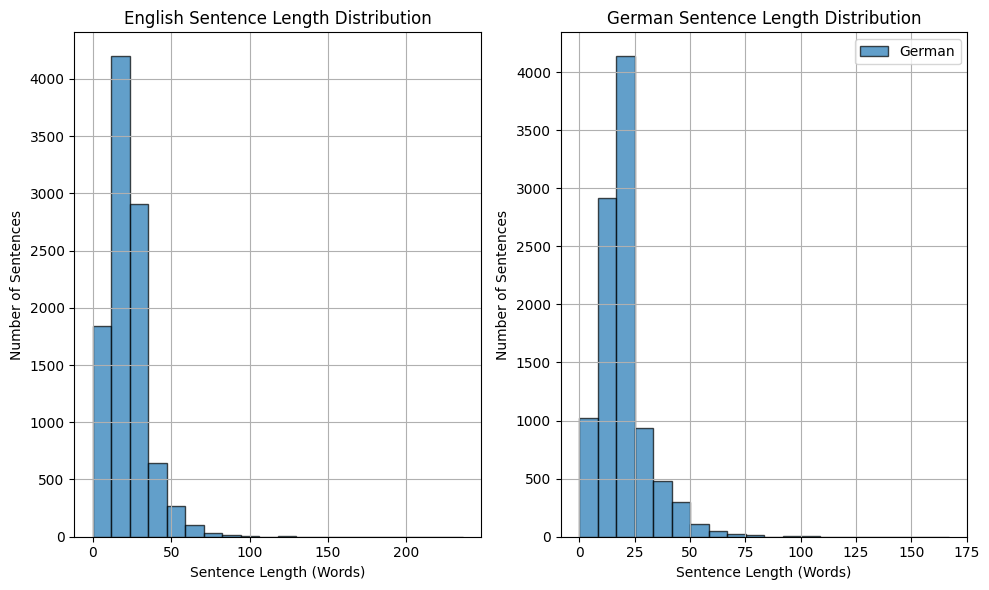

In [ ]:
english_sentences = merged_df["English"].tolist()
german_sentences = merged_df["German"].tolist()

# Calculate sentence lengths
english_lengths = [len(sentence.split()) for sentence in english_sentences]
german_lengths = [len(sentence.split()) for sentence in german_sentences]

# Create a histogram plot with two subplots
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

plt.subplot(1, 2, 1)  # First subplot for English lengths
plt.hist(english_lengths, bins=20, edgecolor='black', alpha=0.7, label='English')
plt.xlabel("Sentence Length (Words)")
plt.ylabel("Number of Sentences")
plt.title("English Sentence Length Distribution")
plt.grid(True)

plt.subplot(1, 2, 2)  # Second subplot for German lengths
plt.hist(german_lengths, bins=20, edgecolor='black', alpha=0.7, label='German')
plt.xlabel("Sentence Length (Words)")
plt.ylabel("Number of Sentences")
plt.title("German Sentence Length Distribution")
plt.grid(True)

# Add a legend to the overall figure
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

>>>> #### **Step 2:** Data cleansing

---



##### Removing special characters, punctuations, white spaces and case normalization.

In [ ]:
def cleanse_dataset(dataset):
    # Remove empty lines
    dataset = dataset[(dataset['German'].str.strip() != '') & (dataset['English'].str.strip() != '')]

    # Trim whitespace using .loc to avoid SettingWithCopyWarning
    dataset.loc[:, 'German'] = dataset['German'].str.strip()
    dataset.loc[:, 'English'] = dataset['English'].str.strip()

    # Remove duplicates
    dataset = dataset.drop_duplicates()

    # Remove non-textual characters (e.g., special characters)
    dataset.loc[:, 'German'] = dataset['German'].str.replace(r'[^a-zA-ZäöüßÄÖÜéèêàâçÇ\s]', '', regex=True)
    dataset.loc[:, 'English'] = dataset['English'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

    # Normalize case
    dataset.loc[:, 'German'] = dataset['German'].str.lower()
    dataset.loc[:, 'English'] = dataset['English'].str.lower()

    return dataset

In [ ]:
cleanse_df = cleanse_dataset(merged_df)
cleanse_df.shape

(9964, 2)

In [ ]:
cleanse_df.head()

,German,English
0,falls es legal ist dann brauchen wir keine debatte zur führen,if it is legal we do not need a debate
1,weitere makrofinanzhilfe für georgien,further macrofinancial assistance for georgia
2,diese forderung verlief im sande zum einen weil das abkommen im juli ausläuft und zum anderen weil wir der ansicht waren dass ein so sensibles thema wie die dauer der vorratsspeicherung erforderlichenfalls gegenstand späterer verhandlungen sein könnte,the request came to nothing firstly because the agreement will come to an end in july and secondly because we have taken the view that a subject as sensitive as the period of data retention could if necessary be a topic for later negotiations
3,so funktioniert der rechtsstaat und lord bethell kann sicher sein dass das dänische rechtswesen entsprechend den prinzipien funktioniert die wir in dieser union hochhalten,that is how the judicial system works and lord bethell can be certain that the danish legal system functions in accordance with all the principles that we uphold in this union
4,wir sind daher durch die weigerung des rates die grundrechtecharta rechtsverbindlich zu machen in eine absurde situation geraten einerseits werden die grundrechte als zwingende konsequenz der anerkennung der würde des menschen betrachtet aber andererseits wird es den menschen verweigert sie tatsächlich als ihr recht geltend machen zu können,the councils refusal to make the charter of fundamental rights binding in law therefore puts us in an absurd situation in which on the one hand fundamental rights are regarded as an inevitable consequence of the recognition of human dignity whilst on the other hand people are denied the chance to exercise their rights


In [ ]:
# Function to remove punctuation from a sentence
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [ ]:
# Remove punctuation from both German and English sentences
cleanse_df['German'] = cleanse_df['German'].apply(remove_punctuation)
cleanse_df['English'] = cleanse_df['English'].apply(remove_punctuation)

In [ ]:
cleanse_df.head()

,German,English
0,falls es legal ist dann brauchen wir keine debatte zur führen,if it is legal we do not need a debate
1,weitere makrofinanzhilfe für georgien,further macrofinancial assistance for georgia
2,diese forderung verlief im sande zum einen weil das abkommen im juli ausläuft und zum anderen weil wir der ansicht waren dass ein so sensibles thema wie die dauer der vorratsspeicherung erforderlichenfalls gegenstand späterer verhandlungen sein könnte,the request came to nothing firstly because the agreement will come to an end in july and secondly because we have taken the view that a subject as sensitive as the period of data retention could if necessary be a topic for later negotiations
3,so funktioniert der rechtsstaat und lord bethell kann sicher sein dass das dänische rechtswesen entsprechend den prinzipien funktioniert die wir in dieser union hochhalten,that is how the judicial system works and lord bethell can be certain that the danish legal system functions in accordance with all the principles that we uphold in this union
4,wir sind daher durch die weigerung des rates die grundrechtecharta rechtsverbindlich zu machen in eine absurde situation geraten einerseits werden die grundrechte als zwingende konsequenz der anerkennung der würde des menschen betrachtet aber andererseits wird es den menschen verweigert sie tatsächlich als ihr recht geltend machen zu können,the councils refusal to make the charter of fundamental rights binding in law therefore puts us in an absurd situation in which on the one hand fundamental rights are regarded as an inevitable consequence of the recognition of human dignity whilst on the other hand people are denied the chance to exercise their rights


##### Plotting word cloud

In [ ]:
# Word Cloud
# Concatenate all German and English sentences into single strings
german_text = ' '.join(cleanse_df['German'])
english_text = ' '.join(cleanse_df['English'])

# Generate the word cloud for German text
wordcloud_german = WordCloud(width=800, height=400, background_color='white').generate(german_text)

# Generate the word cloud for English text
wordcloud_english = WordCloud(width=800, height=400, background_color='white').generate(english_text)

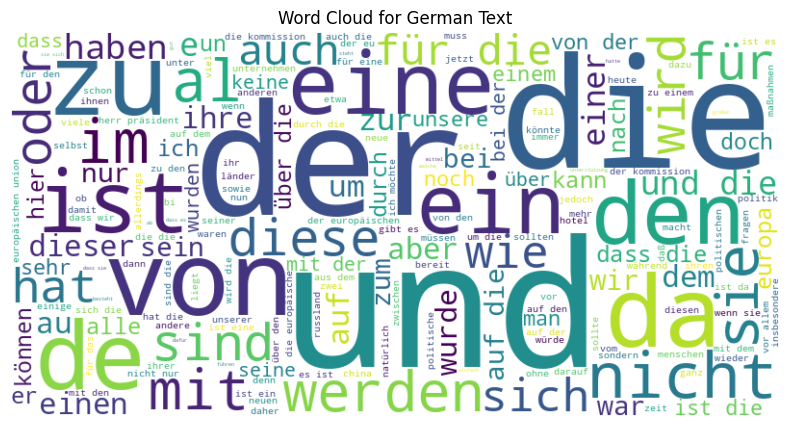

In [ ]:
# Plot the word cloud for German text
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_german, interpolation='bilinear')
plt.title('Word Cloud for German Text')
plt.axis('off')
plt.show()

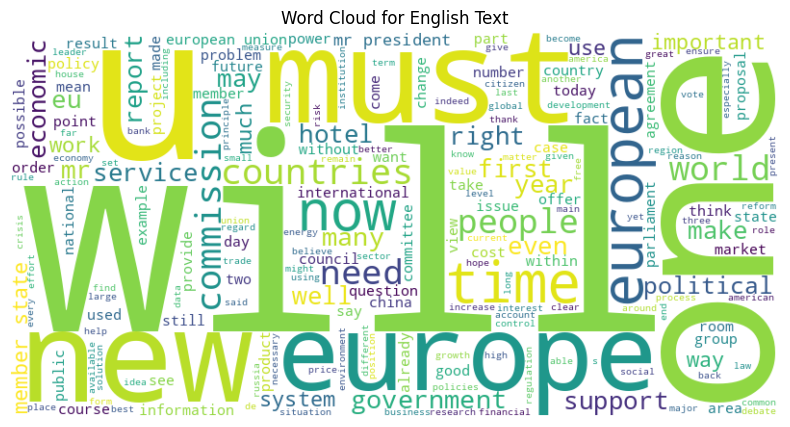

In [ ]:
# Plot the word cloud for English text
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_english, interpolation='bilinear')
plt.title('Word Cloud for English Text')
plt.axis('off')
plt.show()

>>>> #### **Step 3:** NLP pre processing - Dataset suitable to be used for AIML model learning
---



##### Tokenization and padding

In [ ]:
# Load the processed dataset
preprocessed_df = cleanse_df

# Split the data into training and testing sets
train_df, test_df = train_test_split(preprocessed_df, test_size=0.2, random_state=42)

# Separate the German and English columns for both training and testing sets
train_german = train_df['German']
train_english = train_df['English']
test_german = test_df['German']
test_english = test_df['English']

# Tokenization
tokenizer_german = Tokenizer()
tokenizer_english = Tokenizer()

tokenizer_german.fit_on_texts(train_german)
tokenizer_english.fit_on_texts(train_english)

train_german_sequences = tokenizer_german.texts_to_sequences(train_german)
train_english_sequences = tokenizer_english.texts_to_sequences(train_english)
test_german_sequences = tokenizer_german.texts_to_sequences(test_german)
test_english_sequences = tokenizer_english.texts_to_sequences(test_english)

In [ ]:
print('Maximum length german sentence: {}'.format(len(max(train_german_sequences,key=len))))
print('Maximum length english sentence: {}'.format(len(max(train_english_sequences,key=len))))

Maximum length german sentence: 167
Maximum length english sentence: 236


In [ ]:
# Check language length
german_vocab = len(tokenizer_german.word_index) + 1
english_vocab = len(tokenizer_english.word_index) + 1
print("German vocabulary is of {} unique words".format(german_vocab))
print("English vocabulary is of {} unique words".format(english_vocab))

German vocabulary is of 28091 unique words
English vocabulary is of 18185 unique words


In [ ]:
max_german_len = int(len(max(train_german_sequences,key=len)))
max_english_len = int(len(max(train_english_sequences,key=len)))

# Adjust padding lengths to be the same
max_len = max(max_german_len, max_english_len)

train_german_padded = pad_sequences(train_german_sequences, maxlen=max_len, padding='post', truncating='post')
train_english_padded = pad_sequences(train_english_sequences, maxlen=max_len, padding='post', truncating='post')
test_german_padded = pad_sequences(test_german_sequences, maxlen=max_len, padding='post', truncating='post')
test_english_padded = pad_sequences(test_english_sequences, maxlen=max_len, padding='post', truncating='post')

# Ensure the target sequences for training are shifted by one time step
train_english_padded_shifted = np.pad(train_english_padded[:, 1:], ((0, 0), (0, 1)), 'constant')
test_english_padded_shifted = np.pad(test_english_padded[:, 1:], ((0, 0), (0, 1)), 'constant')

In [ ]:
# Verify the shapes of the input data
print(f"Shape of train_german_padded: {train_german_padded.shape}")
print(f"Shape of train_english_padded_shifted: {train_english_padded_shifted.shape}")
print(f"Shape of test_german_padded: {test_german_padded.shape}")
print(f"Shape of test_english_padded_shifted: {test_english_padded_shifted.shape}")

Shape of train_german_padded: (7971, 236)
Shape of train_english_padded_shifted: (7971, 236)
Shape of test_german_padded: (1993, 236)
Shape of test_english_padded_shifted: (1993, 236)


##### Pickle the preprocessed data

In [ ]:
import pickle
import os

# Define the paths
tokenizer_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/tokenizers/'
data_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/tokenizers/'

# Save the tokenizers
with open(tokenizer_path + 'tokenizer_german.pkl', 'wb') as file:
    pickle.dump(tokenizer_german, file)
with open(tokenizer_path + 'tokenizer_english.pkl', 'wb') as file:
    pickle.dump(tokenizer_english, file)

# Save the preprocessed data
np.save(data_path + 'train_german_padded.npy', train_german_padded)
np.save(data_path + 'train_english_padded_shifted.npy', train_english_padded_shifted)
np.save(data_path + 'test_german_padded.npy', test_german_padded)
np.save(data_path + 'test_english_padded_shifted.npy', test_english_padded_shifted)

print("Tokenizers and data saved successfully.")

Tokenizers and data saved successfully.


#####Loading pickled file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle

# Load German tokenizer
with open('/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/tokenizers/tokenizer_german.pkl', 'rb') as f:
    german_tokenizer = pickle.load(f)

# Load English tokenizer
with open('/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/tokenizers/tokenizer_english.pkl', 'rb') as f:
    english_tokenizer = pickle.load(f)

    import numpy as np

# Load preprocessed data
train_german_padded = np.load('/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/tokenizers/train_german_padded.npy')
test_german_padded = np.load('/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/tokenizers/test_german_padded.npy')
train_english_padded_shifted = np.load('/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/tokenizers/train_english_padded_shifted.npy')
test_english_padded_shifted = np.load('/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/tokenizers/test_english_padded_shifted.npy')

print("Data and tokenizers loaded.")

Data and tokenizers loaded.


In [ ]:
import pandas as pd

# Convert the NumPy array to a Pandas DataFrame
X_train_df = pd.DataFrame(train_german_padded)

# Now you can use the .head() method
X_train_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,226,227,228,229,230,231,232,233,234,235
0,12,9834,9,380,447,4548,27,20,6135,34,...,0,0,0,0,0,0,0,0,0,0
1,17,821,39,9839,1333,6136,2,9840,4,77,...,0,0,0,0,0,0,0,0,0,0
2,1,3631,9843,9,10,36,721,9844,148,1,...,0,0,0,0,0,0,0,0,0,0
3,874,9845,61,6137,83,9846,3,26,9847,427,...,0,0,0,0,0,0,0,0,0,0
4,27,3633,9848,10,9849,3,6138,3005,57,9850,...,0,0,0,0,0,0,0,0,0,0
5,9852,89,6139,9853,9854,6140,9855,9856,1,9857,...,0,0,0,0,0,0,0,0,0,0
6,296,979,4,1,2559,2,626,12,3007,2,...,0,0,0,0,0,0,0,0,0,0
7,213,9859,5,141,213,9860,5,477,8,9861,...,0,0,0,0,0,0,0,0,0,0
8,32,339,318,9868,1217,40,48,3009,297,23,...,0,0,0,0,0,0,0,0,0,0
9,16,187,3010,53,155,13,6,315,5,373,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Convert the NumPy array to a Pandas DataFrame
y_train_df = pd.DataFrame(test_german_padded)

# Now you can use the .head() method
y_train_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,226,227,228,229,230,231,232,233,234,235
0,43,207,90,284,14,1116,34,1117,2404,1,...,0,0,0,0,0,0,0,0,0,0
1,8,723,61,1,2109,1441,9,20,1108,1980,...,0,0,0,0,0,0,0,0,0,0
2,16,9,20,5,3185,3,1598,5,6867,54,...,0,0,0,0,0,0,0,0,0,0
3,88,10963,1,3354,1,4,1447,2921,3682,596,...,0,0,0,0,0,0,0,0,0,0
4,4,53,679,710,25,1,13,24,5168,4,...,0,0,0,0,0,0,0,0,0,0
5,19,33,16,126,13,324,2866,2324,1,66,...,0,0,0,0,0,0,0,0,0,0
6,1,2659,124,2706,25,7,6,2556,2,4,...,0,0,0,0,0,0,0,0,0,0
7,29,10,314,425,34,23898,7000,1704,0,0,...,0,0,0,0,0,0,0,0,0,0
8,13,36,303,30,12,299,8965,1391,1,1,...,0,0,0,0,0,0,0,0,0,0
9,68,147,103,4,2,861,5,9638,6664,251,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
german_vocab_size = len(german_tokenizer.word_index) + 1
english_vocab_size = len(english_tokenizer.word_index) + 1
german_max_len = train_german_padded.shape[1]
english_max_len = test_german_padded.shape[1]

In [ ]:
# Assuming these variables have been calculated in your script
print("German Vocabulary Size:", german_vocab_size)
print("English Vocabulary Size:", english_vocab_size)
print("German Max Length:", german_max_len)
print("English Max Length:", english_max_len)

German Vocabulary Size: 28091
English Vocabulary Size: 18185
German Max Length: 236
English Max Length: 236


>>>> #### **Step 4:** Design, train and test simple RNN & LSTM model

---



##### Simple RNN model

In [ ]:
# Define the model
simple_rnn_model = Sequential()
simple_rnn_model.add(SimpleRNN(256, input_shape=(max_len, 1), return_sequences=True))
simple_rnn_model.add(Dense(english_vocab, activation='softmax'))

# Compile the model
simple_rnn_model.compile(optimizer= Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
simple_rnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 236, 256)          66048     
                                                                 
 dense_11 (Dense)            (None, 236, 18185)        4673545   
                                                                 
Total params: 4739593 (18.08 MB)
Trainable params: 4739593 (18.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the callbacks
rnn_checkpoint_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints/rnn_model_checkpoint.h5'
rnn_checkpoint = ModelCheckpoint(
    filepath=rnn_checkpoint_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [ ]:
# Train the model with callbacks
history = simple_rnn_model.fit(
    train_german_padded,
    np.expand_dims(train_english_padded_shifted, -1),
    epochs=10,
    batch_size=128,
    validation_data=(test_german_padded, np.expand_dims(test_english_padded_shifted, -1)),
    callbacks=[rnn_checkpoint, early_stopping]
)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 2.7341 - accuracy: 0.8503
Epoch 1: val_loss improved from inf to 0.66182, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints/rnn_model_checkpoint.h5
63/63 [==============================] - 16s 229ms/step - loss: 2.7341 - accuracy: 0.8503 - val_loss: 0.6618 - val_accuracy: 0.9171
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.9111
Epoch 2: val_loss improved from 0.66182 to 0.61925, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints/rnn_model_checkpoint.h5
63/63 [==============================] - 15s 237ms/step - loss: 0.7064 - accuracy: 0.9111 - val_loss: 0.6192 - val_accuracy: 0.9200
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.9138
Epoch 3: val_loss improved from 0.61925 to 0.61592, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints/rnn_model_checkpoint.h5
63/63 [==============================] - 15s 236ms/step - loss: 0.6899 - accuracy: 0.9138 - val_loss: 0.6159 - val_accuracy: 0.9200
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.6970 - accuracy: 0.9138
Epoch 4: val_loss did not improve from 0.61592
63/63 [===

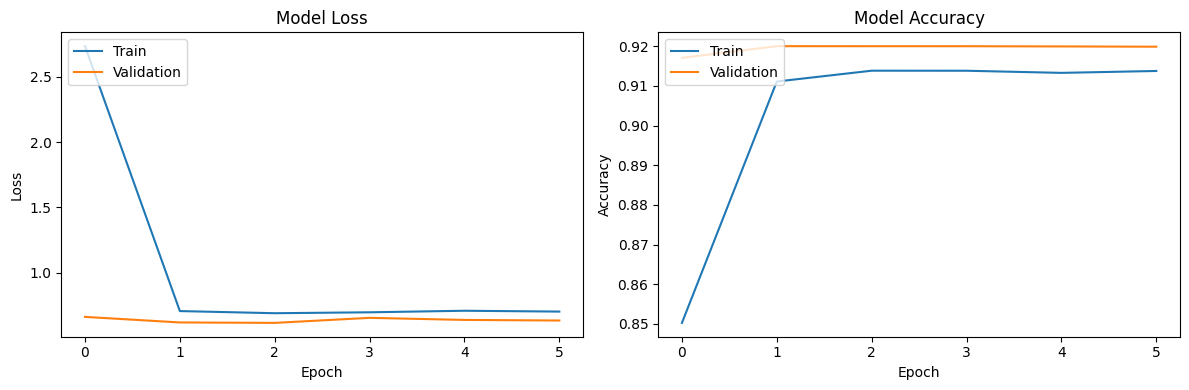

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Save the entire model (architecture + weights)
simple_rnn_model.save('/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints/rnn_model_checkpoint.h5')

In [ ]:
# Load the weights into the model
rnn_checkpoint_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints/rnn_model_checkpoint.h5'
best_rnn_model=load_model(rnn_checkpoint_path)

In [ ]:
test_loss, test_accuracy = best_rnn_model.evaluate(test_german_padded, np.expand_dims(test_english_padded_shifted, -1))

print(f"Validation Loss: {test_loss}, Validation Accuracy: {test_accuracy}")

63/63 [==============================] - 3s 44ms/step - loss: 0.6340 - accuracy: 0.9199
Validation Loss: 0.634004533290863, Validation Accuracy: 0.9198721051216125


In [ ]:
accuracy = test_accuracy

In [ ]:
# Store accuracy in a dataframe
results_df = pd.DataFrame({'Model': ['RNN'], 'Accuracy': [accuracy * 100]})
results_df

,Model,Accuracy
0,RNN,91.987211


In [ ]:
# Choose 5 random indices from test set
random_indices = random.sample(range(len(test_german_padded)), 5)

# Select the random samples from X_test and y_test
X_sample = test_german_padded[random_indices]
y_sample_actual = test_english_padded_shifted[random_indices]

# Predict using the RNN model
y_sample_pred = best_rnn_model.predict(X_sample)

# Decode sequences from indices to words using tokenizer
def decode_sequence(tokenizer, sequence):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    decoded_sentence = ' '.join(reverse_word_map.get(token, '<unk>') for token in sequence if token != 0)
    return decoded_sentence

# Decode actual and predicted sequences
sample_actual_decoded = [decode_sequence(tokenizer_english, seq) for seq in y_sample_actual]
sample_pred_decoded = [decode_sequence(tokenizer_english, seq.argmax(axis=-1)) for seq in y_sample_pred]

# Print actual and predicted sequences
for i in range(len(random_indices)):
    print(f"Example {i + 1}:")
    print(f"Actual English:   {sample_actual_decoded[i]}")
    print(f"Predicted English: {sample_pred_decoded[i]}\n")

1/1 [==============================] - 0s 205ms/step
Example 1:
Actual English:   for a wealthy ageing europe immigration is indeed a reality
Predicted English: the the to the the the the the the

Example 2:
Actual English:   they have offered a certain level of services but not the
Predicted English: the a the of the

Example 3:
Actual English:   the focus for the lisbon agenda should not be international benchmarking
Predicted English: the a the the

Example 4:
Actual English:   we would refer here to other existing sanctions such as in the agricultural sector or the structural funds where the
Predicted English: the the the the the the the the the the the the the the

Example 5:
Actual English:   a year of the persian calendar has months the order names and of which can be seen in
Predicted English: the the the the the and the the



##### Simple LSTM model

In [ ]:
# Define the model
simple_lstm_model = Sequential()
simple_lstm_model.add(LSTM(256, input_shape=(max_len, 1), return_sequences=True))
simple_lstm_model.add(Dense(english_vocab, activation='softmax'))

# Compile the model
simple_lstm_model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
simple_lstm_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 236, 256)          264192    
                                                                 
 dense_12 (Dense)            (None, 236, 18185)        4673545   
                                                                 
Total params: 4937737 (18.84 MB)
Trainable params: 4937737 (18.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the callbacks
lstm_checkpoint_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints/lstm_model_checkpoint.h5'
lstm_checkpoint = ModelCheckpoint(
    filepath=lstm_checkpoint_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Train the model with callbacks
history = simple_lstm_model.fit(
    train_german_padded,
    np.expand_dims(train_english_padded_shifted, -1),
    epochs=10,
    batch_size=128,
    validation_data=(test_german_padded, np.expand_dims(test_english_padded_shifted, -1)),
    callbacks=[lstm_checkpoint, early_stopping]
)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 2.8085 - accuracy: 0.9047
Epoch 1: val_loss improved from inf to 0.63387, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints/lstm_model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 160s 3s/step - loss: 2.8085 - accuracy: 0.9047 - val_loss: 0.6339 - val_accuracy: 0.9203
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.9141
Epoch 2: val_loss improved from 0.63387 to 0.61824, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints/lstm_model_checkpoint.h5
63/63 [==============================] - 152s 2s/step - loss: 0.6940 - accuracy: 0.9141 - val_loss: 0.6182 - val_accuracy: 0.9204
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.9141
Epoch 3: val_loss improved from 0.61824 to 0.61504, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints/lstm_model_checkpoint.h5
63/63 [==============================] - 152s 2s/step - loss: 0.6866 - accuracy: 0.9141 - val_loss: 0.6150 - val_accuracy: 0.9204
Epoch 4/10
6

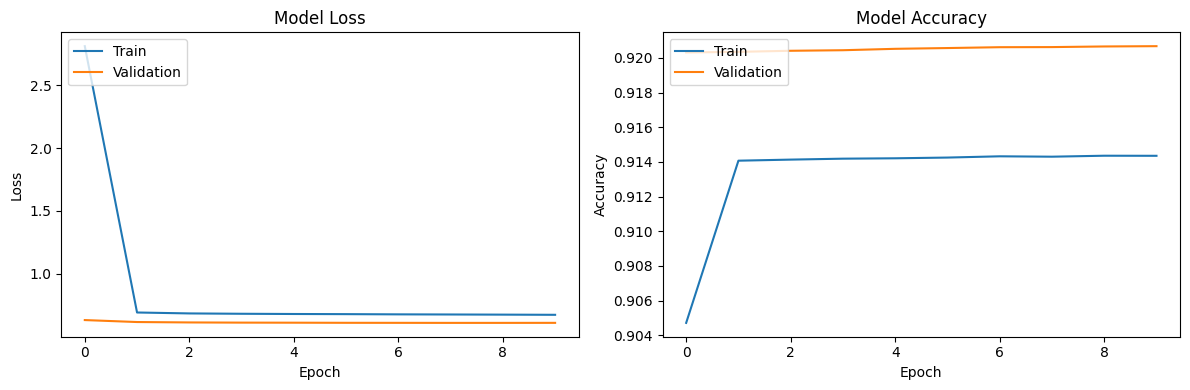

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
lstm_checkpoint_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints/lstm_model_checkpoint.h5'

In [ ]:
# Load best LSTM model from checkpoint
best_lstm_model = load_model(lstm_checkpoint_path)
best_lstm_model.load_weights(lstm_checkpoint_path)

In [ ]:
test_loss, test_accuracy = best_lstm_model.evaluate(test_german_padded, np.expand_dims(test_english_padded_shifted, -1))

63/63 [==============================] - 2s 28ms/step - loss: 0.6115 - accuracy: 0.9206


In [ ]:
print(f"Validation Loss: {test_loss}, Validation Accuracy: {test_accuracy}")

Validation Loss: 0.6114836931228638, Validation Accuracy: 0.9206289649009705


In [ ]:
accuracy = test_accuracy

In [ ]:
# Store accuracy in a dataframe
lstm_results_df = pd.DataFrame({'Model': ['LSTM'], 'Accuracy': [accuracy * 100]})
lstm_results_df

,Model,Accuracy
0,LSTM,92.062896


In [ ]:
# Choose 5 random indices from test set
random_indices = random.sample(range(len(test_german_padded)), 5)

# Select the random samples from X_test and y_test
X_sample = test_german_padded[random_indices]
y_sample_actual = test_english_padded_shifted[random_indices]

# Predict using the RNN model
y_sample_pred = best_lstm_model.predict(X_sample)

# Decode sequences from indices to words using tokenizer
def decode_sequence(tokenizer, sequence):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    decoded_sentence = ' '.join(reverse_word_map.get(token, '<unk>') for token in sequence if token != 0)
    return decoded_sentence

# Decode actual and predicted sequences
sample_actual_decoded = [decode_sequence(tokenizer_english, seq) for seq in y_sample_actual]
sample_pred_decoded = [decode_sequence(tokenizer_english, seq.argmax(axis=-1)) for seq in y_sample_pred]

# Print actual and predicted sequences
for i in range(len(random_indices)):
    print(f"Example {i + 1}:")
    print(f"Actual English:   {sample_actual_decoded[i]}")
    print(f"Predicted English: {sample_pred_decoded[i]}\n")

1/1 [==============================] - 0s 372ms/step
Example 1:
Actual English:   ought to realise that this is not a sensible strategy
Predicted English: the the the the the

Example 2:
Actual English:   provides a example
Predicted English: the the the the the the

Example 3:
Actual English:   from imperial times the hill of next to piazza venezia has always been the seat of the government in rome
Predicted English: the

Example 4:
Actual English:   has the same active as brand name and is equivalent in effect strength and
Predicted English: the the the the the

Example 5:
Actual English:   european court of human rights should administer justice and not become a for ideological and interests
Predicted English: is the the the the the the



##### Combined results from simpe RNN model and simple LSTM model

In [ ]:
# Combine RNN and LSTM results
combined_results_df = pd.concat([results_df, lstm_results_df], ignore_index=True)
combined_results_df

,Model,Accuracy
0,RNN,91.987211
1,LSTM,92.062896


>>>> #### **Step 5:** Interim report
---



[Interim report link](https://drive.google.com/file/d/1UQbZu7yesQGVK8NnD9dPXIwJqUPw8jiN/view?usp=sharing)





---


##### Insights: <br>

---


-  **Dataset:**
     we have chosen to proceed with a combined dataset of sentences each from Europarl v7, Common Crawl, and WMT News Commentary, we limited the data due to the downside of a larger dataset is that the increased in training time and computational resources required.
<br>
-  **Simple RNN Model**
    The Simple RNN layer processes sequences with 256 units and updates hidden states at each time step, while the Dense layer with a softmax activation outputs word probabilities for each step.
<br>
-  **Simple LSTM Model**
    The LSTM layer with 256 units manages long-range dependencies using gating mechanisms, while the Dense layer with a softmax activation provides word probabilities at each time step.
<br>
-  **Model Performance:**
    The LSTM model achieved a slightly higher validation accuracy (0.08% increase) compared to the simple RNN model. This suggests that the LSTM architecture might be better suited for capturing long-term dependencies in sentences, leading to potentially better translations.
<br>
- **Predictions:**
    The predictions from both models seem to struggle with generating meaningful sequences, often defaulting to repetitive words or placeholders. This might indicate that further tuning or advanced techniques like attention mechanisms might improve translation quality.
<br>
- **Limitations of Model:**
    While accuracy provides some indication of model performance, the models itself are very simple. In the future we can try with advanced architecture such as encoder-decoder, bi-directional, etc.


---



>> ## **2. Milestone 2:**

---



>>> **Input:** Preprocessed output from Milestone-1

---



>>> **Process:**

---



>>>> #### **Step 1:** Design, train and test RNN & LSTM model with embeddings

---



In [ ]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Verify the shapes of the input data

print(f"The target sequences for Train are shifted by one time step: {train_english_padded_shifted.shape}")
print(f"The target sequences for Test are shifted by one time step: {test_english_padded_shifted.shape}")
print("")
print(f"Max length between max of english and german length: {max_len}")
print("")
print("German vocabulary is of {} unique words".format(german_vocab))
print("English vocabulary is of {} unique words".format(english_vocab))
print("")
print(f"Shape of train_german_padded: {train_german_padded.shape}")
print(f"Shape of train_english_padded_shifted: {train_english_padded_shifted.shape}")
print(f"Shape of test_german_padded: {test_german_padded.shape}")
print(f"Shape of test_english_padded_shifted: {test_english_padded_shifted.shape}")

The target sequences for Train are shifted by one time step: (7971, 236)
The target sequences for Test are shifted by one time step: (1993, 236)

Max length between max of english and german length: 236

German vocabulary is of 28091 unique words
English vocabulary is of 18185 unique words

Shape of train_german_padded: (7971, 236)
Shape of train_english_padded_shifted: (7971, 236)
Shape of test_german_padded: (1993, 236)
Shape of test_english_padded_shifted: (1993, 236)


##### RNN model with embeddings

We design an RNN model with embedding,which includes an embedding layer that maps input sequences to 128-dimensional vectors, a SimpleRNN layer with 256 hidden units that processes these sequences, and a dense layer that produces predictions across 18,185 classes for each time step in the sequence.








In [ ]:
# Define embedding dimensions (adjust as needed)
embedding_dim = 128

# Define RNN Model with Embeddings
def create_rnn_model(vocab_size, embedding_dim):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
  model.add(SimpleRNN(256, return_sequences=True))
  model.add(Dense(english_vocab, activation='softmax'))
  model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
  # Print model summary
  model.summary()
  return model

In [ ]:
embedded_rnn_model = create_rnn_model(german_vocab, embedding_dim)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 236, 128)          3595648   
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 236, 256)          98560     
                                                                 
 dense_13 (Dense)            (None, 236, 18185)        4673545   
                                                                 
Total params: 8367753 (31.92 MB)
Trainable params: 8367753 (31.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define checkpoint path for RNN model with embeddings
rnn_emb_checkpoint_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints1/rnn_emb_model_checkpoint.h5'
rnn_emb_checkpoint = ModelCheckpoint(rnn_emb_checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
# Train Embedded RNN model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history_rnn = embedded_rnn_model.fit(
  train_german_padded,
  np.expand_dims(train_english_padded_shifted, -1),
  epochs=10,
  batch_size=128,
  validation_data=(test_german_padded, np.expand_dims(test_english_padded_shifted, -1)),
  callbacks=[rnn_emb_checkpoint, early_stopping]
)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 2.5655 - accuracy: 0.8977
Epoch 1: val_accuracy improved from -inf to 0.91759, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints1/rnn_emb_model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 133s 2s/step - loss: 2.5655 - accuracy: 0.8977 - val_loss: 0.8927 - val_accuracy: 0.9176
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 1.0285 - accuracy: 0.9088
Epoch 2: val_accuracy did not improve from 0.91759
63/63 [==============================] - 127s 2s/step - loss: 1.0285 - accuracy: 0.9088 - val_loss: 0.9226 - val_accuracy: 0.9157
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 1.0834 - accuracy: 0.9060
Epoch 3: val_accuracy improved from 0.91759 to 0.91938, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints1/rnn_emb_model_checkpoint.h5
63/63 [==============================] - 128s 2s/step - loss: 1.0834 - accuracy: 0.9060 - val_loss: 0.8340 - val_accuracy: 0.9194
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 1.1356 - accuracy: 0.9032
Epoch 4: val_accuracy did not improve from 0.91938
63/63 [======

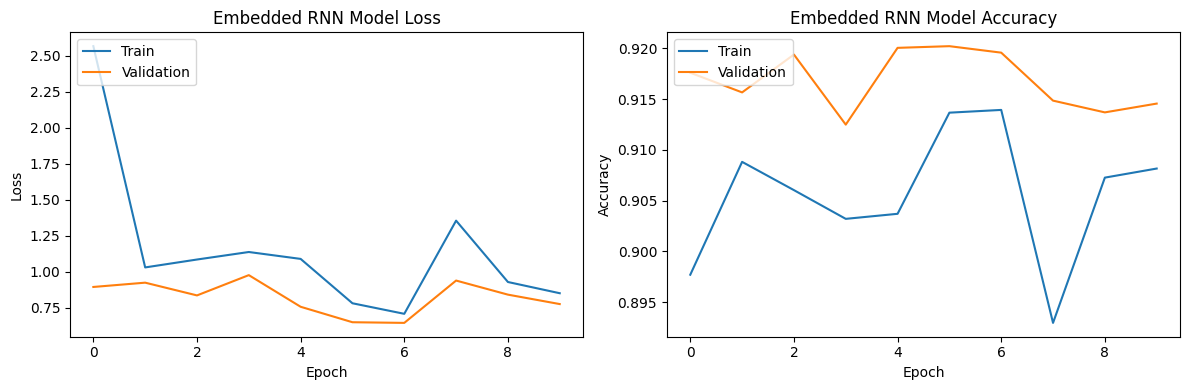

In [ ]:
# Plot training & validation loss values for Embedded RNN Model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Embedded RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values for Embedded RNN Model
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('Embedded RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Load best RNN model with embeddings from checkpoint
best_rnn_emb_model = load_model(rnn_emb_checkpoint_path)

In [ ]:
test_loss, test_accuracy = best_rnn_emb_model.evaluate(test_german_padded, np.expand_dims(test_english_padded_shifted, -1))
print(" ")
print(f"Embedded RNN Validation Loss: {test_loss:.2f}, Embedded RNN Accuracy: {test_accuracy*100:.2f}")

63/63 [==============================] - 3s 43ms/step - loss: 0.6477 - accuracy: 0.9202
 
Embedded RNN Validation Loss: 0.65, Embedded RNN Accuracy: 92.02


In [ ]:
# Store accuracy in a dataframe
results_rnn_emb_df = pd.DataFrame({'Model': ['RNN with Embeddings'], 'Accuracy': [test_accuracy * 100]})
results_rnn_emb_df

,Model,Accuracy
0,RNN with Embeddings,92.020375


In [ ]:
import random

# Choose 5 random indices from test set
random_indices = random.sample(range(len(test_german_padded)), 5)

# Select the random samples from X_test and y_test
X_sample = test_german_padded[random_indices]
y_sample_actual = test_english_padded_shifted[random_indices]

# Predict using the RNN model
y_sample_pred = best_rnn_emb_model.predict(X_sample)

# Decode sequences from indices to words using tokenizer
def decode_sequence(tokenizer, sequence):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    decoded_sentence = ' '.join(reverse_word_map.get(token, '<unk>') for token in sequence if token != 0)
    return decoded_sentence

# Decode actual and predicted sequences
sample_actual_decoded = [decode_sequence(english_tokenizer, seq) for seq in y_sample_actual]
sample_pred_decoded = [decode_sequence(english_tokenizer, seq.argmax(axis=-1)) for seq in y_sample_pred]

# Print actual and predicted sequences
for i in range(len(random_indices)):
    print(f"Example {i + 1}:")
    print(f"Actual English:   {sample_actual_decoded[i]}")
    print(f"Predicted English: {sample_pred_decoded[i]}\n")

1/1 [==============================] - 0s 197ms/step
Example 1:
Actual English:   think we also need to take on board that they come with their own culture tradition and languages
Predicted English: the the

Example 2:
Actual English:   situation is likely to affect their educational and career path with a longterm impact on the societies in which they live
Predicted English: is the

Example 3:
Actual English:   at the same time in australia his place of residence and was therefore not able to take part in the
Predicted English: is the

Example 4:
Actual English:   wrote in the first century not a year passed in which india did not take million away from that trade
Predicted English: is the

Example 5:
Actual English:   is therefore no conflict between what is good for europes citizens and what is good for europes businesses
Predicted English: is the



##### LSTM model with embeddings

We define a LSTM model with embeddings, that features an embedding layer for mapping inputs to 128-dimensional vectors, an LSTM layer with 256 units for capturing long-term dependencies in the sequences, and a dense layer that outputs predictions across 18,185 classes for each time step.

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

# Define LSTM Model with Embeddings
def create_lstm_model(vocab_size, embedding_dim):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
  model.add(LSTM(256, return_sequences=True))
  model.add(Dense(english_vocab, activation='softmax'))
  model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
  # Print model summary
  model.summary()
  return model

In [ ]:
embedded_lstm_model = create_lstm_model(german_vocab, embedding_dim)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 236, 128)          3595648   
                                                                 
 lstm_7 (LSTM)               (None, 236, 256)          394240    
                                                                 
 dense_14 (Dense)            (None, 236, 18185)        4673545   
                                                                 
Total params: 8663433 (33.05 MB)
Trainable params: 8663433 (33.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define checkpoint path for LSTM model with embeddings
lstm_emb_checkpoint_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints1/lstm_emb_model_checkpoint.h5'
lstm_emb_checkpoint = ModelCheckpoint(lstm_emb_checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
# Train Embedded LSTM model
history_lstm = embedded_lstm_model.fit(
  train_german_padded,
  np.expand_dims(train_english_padded_shifted, -1),
  epochs=10,
  batch_size=128,
  validation_data=(test_german_padded, np.expand_dims(test_english_padded_shifted, -1)),
  callbacks=[lstm_emb_checkpoint, early_stopping]
)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 2.8558 - accuracy: 0.8989
Epoch 1: val_accuracy improved from -inf to 0.91985, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints1/lstm_emb_model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 28s 404ms/step - loss: 2.8558 - accuracy: 0.8989 - val_loss: 0.8305 - val_accuracy: 0.9199
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.9095 - accuracy: 0.9127
Epoch 2: val_accuracy improved from 0.91985 to 0.91999, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints1/lstm_emb_model_checkpoint.h5
63/63 [==============================] - 10s 161ms/step - loss: 0.9095 - accuracy: 0.9127 - val_loss: 0.8043 - val_accuracy: 0.9200
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.8282 - accuracy: 0.9136
Epoch 3: val_accuracy did not improve from 0.91999
63/63 [==============================] - 10s 151ms/step - loss: 0.8282 - accuracy: 0.9136 - val_loss: 0.6910 - val_accuracy: 0.9199
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.7332 - accuracy: 0.9137
Epoch 4: val_accuracy did not improve from 0.91999
63/63 

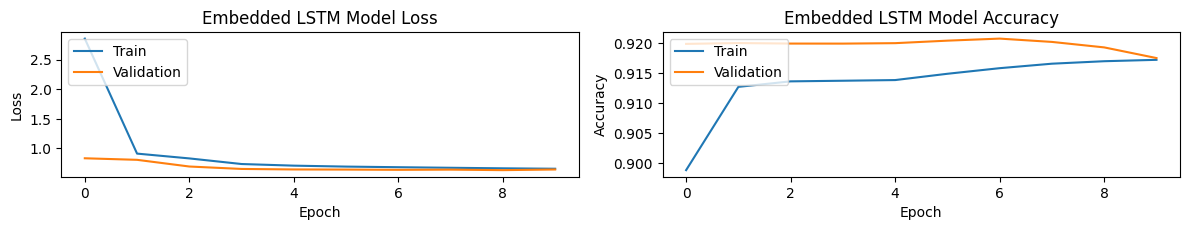

In [ ]:
# Plot training & validation loss values for Embedded LSTM Model
plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Embedded LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values for Embedded LSTM Model
plt.subplot(2, 2, 2)
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Embedded LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Load best LSTM model with embeddings from checkpoint
best_lstm_emb_model = load_model(lstm_emb_checkpoint_path)

In [ ]:
test_loss, test_accuracy = best_lstm_emb_model.evaluate(test_german_padded, np.expand_dims(test_english_padded_shifted, -1))
print(" ")
print(f"Embedded LSTM Validation Loss: {test_loss:.2f}, Embedded LSTM Accuracy: {test_accuracy*100:.2f}")

63/63 [==============================] - 2s 28ms/step - loss: 0.6349 - accuracy: 0.9207
 
Embedded LSTM Validation Loss: 0.63, Embedded LSTM Accuracy: 92.07


In [ ]:
# Store accuracy in a dataframe
results_lstm_emb_df = pd.DataFrame({'Model': ['LSTM with Embeddings'], 'Accuracy': [test_accuracy * 100]})
results_lstm_emb_df

,Model,Accuracy
0,LSTM with Embeddings,92.072892


In [ ]:
import random

# Choose 5 random indices from test set
random_indices = random.sample(range(len(test_german_padded)), 5)

# Select the random samples from X_test and y_test
X_sample = test_german_padded[random_indices]
y_sample_actual = test_english_padded_shifted[random_indices]

# Predict using the RNN model
y_sample_pred = best_lstm_emb_model.predict(X_sample)

# Decode sequences from indices to words using tokenizer
def decode_sequence(tokenizer, sequence):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    decoded_sentence = ' '.join(reverse_word_map.get(token, '<unk>') for token in sequence if token != 0)
    return decoded_sentence

# Decode actual and predicted sequences
sample_actual_decoded = [decode_sequence(english_tokenizer, seq) for seq in y_sample_actual]
sample_pred_decoded = [decode_sequence(english_tokenizer, seq.argmax(axis=-1)) for seq in y_sample_pred]

# Print actual and predicted sequences
for i in range(len(random_indices)):
    print(f"Example {i + 1}:")
    print(f"Actual English:   {sample_actual_decoded[i]}")
    print(f"Predicted English: {sample_pred_decoded[i]}\n")

1/1 [==============================] - 0s 374ms/step
Example 1:
Actual English:   with small and parking space
Predicted English: is is is the the

Example 2:
Actual English:   the governments of the union really wish to bring their citizens closer to the union then it is in their interests and those of their people to ensure that referendums are held in order to legitimise what is being proposed in their name
Predicted English: is is the

Example 3:
Actual English:   germany the electorate seems to chancellor gerhard out of with his to the neoliberal project
Predicted English: is is the the the the the the the the the the the

Example 4:
Actual English:   you like hotel jerusalem
Predicted English: is is is

Example 5:
Actual English:   effect however what we see is the legislative body held by a of expert
Predicted English: is is



##### Combined results of all models

In [ ]:
# Combine RNN and LSTM results
combined_results_df = pd.concat([results_df, lstm_results_df, results_rnn_emb_df, results_lstm_emb_df], ignore_index=True)
combined_results_df

,Model,Accuracy
0,RNN,91.987211
1,LSTM,92.062896
2,RNN with Embeddings,92.020375
3,LSTM with Embeddings,92.072892


##### Insights

 * LSTM-based models show slightly higher accuracy (up to 92.0729%) compared to RNN models, indicating they better handle sequential dependencies in the data.

 * Adding embeddings to LSTM models slightly improves accuracy, but the gains are minimal (up to 92.0729% vs. 92.0204% for LSTM without embeddings).

* **Prediction Issues:** Despite high accuracy, the predictions from all models are repetitive or meaningless, suggesting issues with overfitting or the need for better contextual handling.

>>>> #### **Step 2:** Design, train and test bidirectional RNN & LSTM model
---



In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dense, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

##### Bidirectional RNN model

We try a bidirectional RNN model, which consists of an embedding layer for token representation, a bidirectional RNN layer with 256 units for contextual processing in both directions, and a Dense layer for generating predictions across a vocabulary of 18,185 tokens.

In [ ]:
embedding_dim = 128
# Define function to create BiRNN model with embeddings
def create_birnn_model(vocab_size, embedding_dim):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
  model.add(Bidirectional(SimpleRNN(256, return_sequences=True)))
  model.add(Dense(english_vocab, activation='softmax'))
  model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
  # Print model summary
  model.summary()
  return model

In [ ]:
birnn_model = create_birnn_model(german_vocab, embedding_dim)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 236, 128)          3595648   
                                                                 
 bidirectional_8 (Bidirecti  (None, 236, 512)          197120    
 onal)                                                           
                                                                 
 dense_15 (Dense)            (None, 236, 18185)        9328905   
                                                                 
Total params: 13121673 (50.06 MB)
Trainable params: 13121673 (50.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define checkpoint path for Bidirectional RNN model with embeddings
bi_rnn_emb_checkpoint_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints1/bi_rnn_emb_model_checkpoint.h5'
bi_rnn_emb_checkpoint = ModelCheckpoint(bi_rnn_emb_checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
# Train BiRNN model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history_birnn = birnn_model.fit(
  train_german_padded,
  np.expand_dims(train_english_padded_shifted, -1),
  epochs=10,
  batch_size=128,
  validation_data=(test_german_padded, np.expand_dims(test_english_padded_shifted, -1)),
  callbacks=[bi_rnn_emb_checkpoint, early_stopping]
)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 2.9384 - accuracy: 0.7757
Epoch 1: val_accuracy improved from -inf to 0.91969, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints1/bi_rnn_emb_model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 36s 530ms/step - loss: 2.9384 - accuracy: 0.7757 - val_loss: 1.1543 - val_accuracy: 0.9197
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 1.0605 - accuracy: 0.9119
Epoch 2: val_accuracy improved from 0.91969 to 0.91985, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints1/bi_rnn_emb_model_checkpoint.h5
63/63 [==============================] - 33s 520ms/step - loss: 1.0605 - accuracy: 0.9119 - val_loss: 0.8808 - val_accuracy: 0.9199
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.9566 - accuracy: 0.9137
Epoch 3: val_accuracy did not improve from 0.91985
63/63 [==============================] - 30s 482ms/step - loss: 0.9566 - accuracy: 0.9137 - val_loss: 0.8434 - val_accuracy: 0.9199
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.8870 - accuracy: 0.9137
Epoch 4: val_accuracy did not improve from 0.91985
63/6

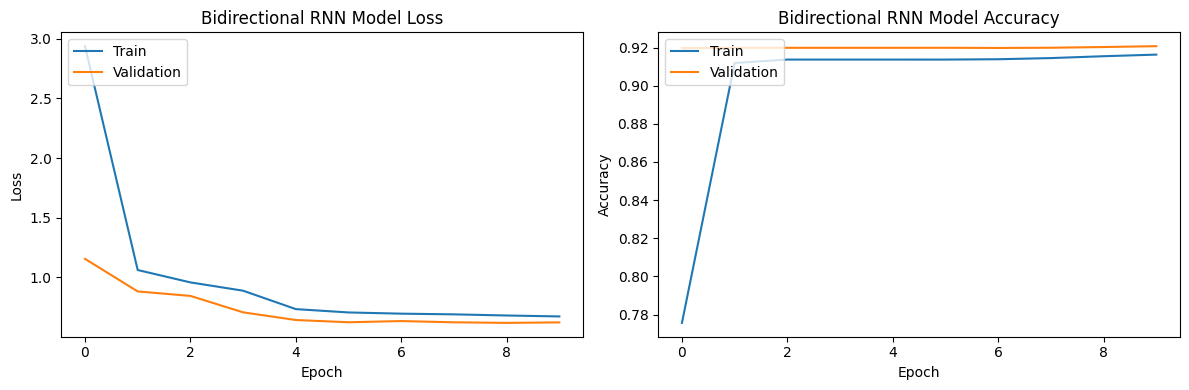

In [ ]:
# Plot training & validation loss values for Bidirectional RNN Model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_birnn.history['loss'])
plt.plot(history_birnn.history['val_loss'])
plt.title('Bidirectional RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values for Bidirectional RNN Model
plt.subplot(1, 2, 2)
plt.plot(history_birnn.history['accuracy'])
plt.plot(history_birnn.history['val_accuracy'])
plt.title('Bidirectional RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Load best Bidirectional RNN model with embeddings from checkpoint
best_bi_rnn_emb_model = load_model(bi_rnn_emb_checkpoint_path)

In [ ]:
test_loss, test_accuracy = best_bi_rnn_emb_model.evaluate(test_german_padded, np.expand_dims(test_english_padded_shifted, -1))
print(" ")
print(f"Bidirectional RNN Validation Loss: {test_loss:.2f}, Bidirectional RNN Accuracy: {test_accuracy*100:.2f}")

63/63 [==============================] - 4s 64ms/step - loss: 0.6212 - accuracy: 0.9207
 
Bidirectional RNN Validation Loss: 0.62, Bidirectional RNN Accuracy: 92.07


In [ ]:
# Store accuracy in a dataframe
results_bi_rnn_emb_df = pd.DataFrame({'Model': ['Bidirectional RNN'], 'Accuracy': [test_accuracy * 100]})
results_bi_rnn_emb_df

,Model,Accuracy
0,Bidirectional RNN,92.07055


In [ ]:
import random

# Choose 5 random indices from test set
random_indices = random.sample(range(len(test_german_padded)), 5)

# Select the random samples from X_test and y_test
X_sample = test_german_padded[random_indices]
y_sample_actual = test_english_padded_shifted[random_indices]

# Predict using the RNN model
y_sample_pred = best_bi_rnn_emb_model.predict(X_sample)

# Decode sequences from indices to words using tokenizer
def decode_sequence(tokenizer, sequence):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    decoded_sentence = ' '.join(reverse_word_map.get(token, '<unk>') for token in sequence if token != 0)
    return decoded_sentence

# Decode actual and predicted sequences
sample_actual_decoded = [decode_sequence(english_tokenizer, seq) for seq in y_sample_actual]
sample_pred_decoded = [decode_sequence(english_tokenizer, seq.argmax(axis=-1)) for seq in y_sample_pred]

# Print actual and predicted sequences
for i in range(len(random_indices)):
    print(f"Example {i + 1}:")
    print(f"Actual English:   {sample_actual_decoded[i]}")
    print(f"Predicted English: {sample_pred_decoded[i]}\n")

1/1 [==============================] - 0s 289ms/step
Example 1:
Actual English:   year has sadly been no exception
Predicted English: the the the the the the

Example 2:
Actual English:   armenian contains of small on your desktop which helps you to type armenian words into without need of any other programs
Predicted English: the the the the the the the the the the the the the the the the

Example 3:
Actual English:   bubbles in the price of say individual stocks happen all the time and dont qualify as an answer to the question
Predicted English: the the the the the

Example 4:
Actual English:   twin peaks itself was further
Predicted English: the the the the the

Example 5:
Actual English:   are aiming at an reduction in the emission of six greenhouse gases
Predicted English: the the the the the the the the



##### Bidirectional LSTM Model with Embeddings

We train a bidirectional LSTM model, which includes an embedding layer for input token representation, a bidirectional LSTM layer with 256 units for capturing context in both directions, and a Dense layer for outputting predictions over a vocabulary of 18,185 tokens.

In [ ]:
# Define function to create BiLSTM model with embeddings
def create_bilstm_model(vocab_size, embedding_dim):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
  model.add(Bidirectional(LSTM(256, return_sequences=True)))
  model.add(Dense(english_vocab, activation='softmax'))
  model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
  # Print model summary
  model.summary()
  return model

bilstm_model = create_bilstm_model(german_vocab, embedding_dim)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 236, 128)          3595648   
                                                                 
 bidirectional_9 (Bidirecti  (None, 236, 512)          788480    
 onal)                                                           
                                                                 
 dense_16 (Dense)            (None, 236, 18185)        9328905   
                                                                 
Total params: 13713033 (52.31 MB)
Trainable params: 13713033 (52.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define checkpoint path for Bidirectional LSTM model with embeddings
bi_lstm_emb_checkpoint_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints1/bi_lstm_emb_model_checkpoint.h5'
bi_lstm_emb_checkpoint = ModelCheckpoint(bi_lstm_emb_checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
# Train Bidirectional LSTM model with embeddings
# Train BiLSTM model
history_bilstm = bilstm_model.fit(
  train_german_padded,
  np.expand_dims(train_english_padded_shifted, -1),
  epochs=10,
  batch_size=128,
  validation_data=(test_german_padded, np.expand_dims(test_english_padded_shifted, -1)),
  callbacks=[bi_lstm_emb_checkpoint, early_stopping]
)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 2.2487 - accuracy: 0.8951
Epoch 1: val_accuracy improved from -inf to 0.91985, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints1/bi_lstm_emb_model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 22s 301ms/step - loss: 2.2487 - accuracy: 0.8951 - val_loss: 0.6464 - val_accuracy: 0.9199
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.7101 - accuracy: 0.9137
Epoch 2: val_accuracy did not improve from 0.91985
63/63 [==============================] - 15s 240ms/step - loss: 0.7101 - accuracy: 0.9137 - val_loss: 0.6517 - val_accuracy: 0.9199
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.7047 - accuracy: 0.9137
Epoch 3: val_accuracy did not improve from 0.91985
63/63 [==============================] - 15s 233ms/step - loss: 0.7047 - accuracy: 0.9137 - val_loss: 0.8753 - val_accuracy: 0.9199
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.7169 - accuracy: 0.9137
Epoch 4: val_accuracy did not improve from 0.91985
63/63 [==============================] - 14s 217ms/step - loss: 0.7169 - accuracy: 0.9137 - val_loss: 0.6354 - val_accuracy: 0.9199
Epoch 5/10
63/63 [===================

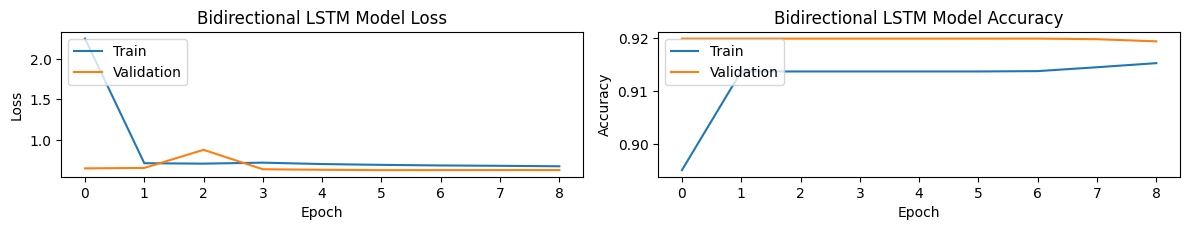

In [ ]:
# Plot training & validation loss values for Bidirectional LSTM Model
plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(history_bilstm.history['loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.title('Bidirectional LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values for Bidirectional LSTM Model
plt.subplot(2, 2, 2)
plt.plot(history_bilstm.history['accuracy'])
plt.plot(history_bilstm.history['val_accuracy'])
plt.title('Bidirectional LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Load best Bidirectional LSTM model with embeddings from checkpoint
best_bi_lstm_emb_model = load_model(bi_lstm_emb_checkpoint_path)

In [ ]:
test_loss, test_accuracy = best_bi_lstm_emb_model.evaluate(test_german_padded, np.expand_dims(test_english_padded_shifted, -1))
print(" ")
print(f"Bidirectional LSTM Validation Loss: {test_loss:.2f}, Bidirectional LSTM Accuracy: {test_accuracy*100:.2f}")

63/63 [==============================] - 3s 36ms/step - loss: 0.6251 - accuracy: 0.9199
 
Bidirectional LSTM Validation Loss: 0.63, Bidirectional LSTM Accuracy: 91.99


In [ ]:
# Store accuracy in a dataframe
results_bi_lstm_emb_df = pd.DataFrame({'Model': ['Bidirectional LSTM'], 'Accuracy': [test_accuracy * 100]})
results_bi_lstm_emb_df

,Model,Accuracy
0,Bidirectional LSTM,91.98572


In [ ]:
import random

# Choose 5 random indices from test set
random_indices = random.sample(range(len(test_german_padded)), 5)

# Select the random samples from X_test and y_test
X_sample = test_german_padded[random_indices]
y_sample_actual = test_english_padded_shifted[random_indices]

# Predict using the RNN model
y_sample_pred = best_bi_lstm_emb_model.predict(X_sample)

# Decode sequences from indices to words using tokenizer
def decode_sequence(tokenizer, sequence):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    decoded_sentence = ' '.join(reverse_word_map.get(token, '<unk>') for token in sequence if token != 0)
    return decoded_sentence

# Decode actual and predicted sequences
sample_actual_decoded = [decode_sequence(english_tokenizer, seq) for seq in y_sample_actual]
sample_pred_decoded = [decode_sequence(english_tokenizer, seq.argmax(axis=-1)) for seq in y_sample_pred]

# Print actual and predicted sequences
for i in range(len(random_indices)):
    print(f"Example {i + 1}:")
    print(f"Actual English:   {sample_actual_decoded[i]}")
    print(f"Predicted English: {sample_pred_decoded[i]}\n")

1/1 [==============================] - 1s 732ms/step
Example 1:
Actual English:   members have asked to speak and i have been unable to allow them all to do so
Predicted English: the the

Example 2:
Actual English:   reason we are there with what is required medical aid sanitation and clean water
Predicted English: the the the the the

Example 3:
Actual English:   convention makes it compulsory for vessels to dispose of their waste while in the port of call in the port installations intended for the purpose and in return requires the states to appropriate installations
Predicted English: 

Example 4:
Actual English:   the blocks are still placed into the key cache as needed by queries
Predicted English: 

Example 5:
Actual English:   
Predicted English: 



##### Combined results of all models

In [ ]:
# Combine all results
combined_results_df = pd.concat([results_df, lstm_results_df, results_rnn_emb_df, results_lstm_emb_df, results_bi_rnn_emb_df, results_bi_lstm_emb_df], ignore_index=True)
combined_results_df

,Model,Accuracy
0,RNN,91.987211
1,LSTM,92.062896
2,RNN with Embeddings,92.020375
3,LSTM with Embeddings,92.072892
4,Bidirectional RNN,92.070550
5,Bidirectional LSTM,91.985720


##### Insights
* LSTM with Embeddings achieved the highest accuracy at 92.072892%, slightly outperforming other models.
* Bidirectional LSTM had the lowest accuracy at 91.985720%, though it was close to the RNN-based models.
* Overall, all models exhibited similar performance, with differences in accuracy being marginal.
* Prediction quality however is bad for all models, being repetitive and meaningless.

>>>> #### **Step 3:** Design, train and test Encoder-Decoder RNN & LSTM model (Optional-If interested can try, but marks will not be reduced if not attempted)

---



In [ ]:
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, LSTM, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

##### Encoder - Decoder RNN

We design a encoder decoder RNN model, which has an encoder-decoder architecture featuring an embedding layer, a bidirectional RNN as the encoder, and a dense layer followed by a sequential layer for sequence generation as the decoder.

In [ ]:
embedding_dim = 128
# Define function to create encoder (shared for RNN and LSTM)
def create_encoder(vocab_size, embedding_dim, units):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
  model.add(Bidirectional(units(256, return_sequences=False)))  # Create an instance of SimpleRNN or LSTM
  model.add(Dense(max_len))
  return model

# Define function to create decoder with attention (shared for RNN and LSTM)
def create_decoder(english_vocab, embedding_dim, units):
  model = Sequential()
  model.add(Embedding(english_vocab, embedding_dim, input_length=max_len))
  model.add(Bidirectional(units(256, return_sequences=True)))
  model.add(Bidirectional(units(256)))
  model.add(RepeatVector(max_len))
  model.add(Dense(english_vocab, activation='softmax'))
  return model

# Define function to create Encoder-Decoder RNN model
def create_encoder_decoder_rnn_model(german_vocab, english_vocab, embedding_dim):
  encoder = create_encoder(german_vocab, embedding_dim, SimpleRNN)
  decoder = create_decoder(english_vocab, embedding_dim, SimpleRNN)

  # Combine encoder and decoder for training
  model = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
  model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
  # Print model summary
  model.summary()
  return model

In [ ]:
encoder_decoder_rnn_model = create_encoder_decoder_rnn_model(german_vocab, english_vocab, embedding_dim)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20_input (InputL  [(None, 236)]             0         
 ayer)                                                           
                                                                 
 embedding_20 (Embedding)    (None, 236, 128)          3595648   
                                                                 
 bidirectional_16 (Bidirect  (None, 512)               197120    
 ional)                                                          
                                                                 
 dense_23 (Dense)            (None, 236)               121068    
                                                                 
 sequential_22 (Sequential)  (None, 236, 18185)        12247433  
                                                                 
Total params: 16161269 (61.65 MB)
Trainable params: 1616126

In [ ]:
# Define checkpoint path for Encoder-Decoder RNN model
enc_dec_rnn_checkpoint_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints1/enc_dec_rnn_model_checkpoint.h5'
enc_dec_rnn_checkpoint = ModelCheckpoint(enc_dec_rnn_checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
# Train Encoder-Decoder RNN model
# Train Encoder-Decoder RNN model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history_encoder_decoder_rnn = encoder_decoder_rnn_model.fit(
  train_german_padded,
  train_english_padded,
  epochs=10,
  batch_size=128,
  validation_data=(test_german_padded, test_english_padded),
  callbacks=[enc_dec_rnn_checkpoint, early_stopping]
)

Epoch 1/10


63/63 [==============================] - ETA: 0s - loss: 1.8751 - accuracy: 0.8948
Epoch 1: val_accuracy improved from -inf to 0.91563, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints1/enc_dec_rnn_model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 53s 771ms/step - loss: 1.8751 - accuracy: 0.8948 - val_loss: 0.8812 - val_accuracy: 0.9156
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.9662 - accuracy: 0.9095
Epoch 2: val_accuracy did not improve from 0.91563
63/63 [==============================] - 47s 747ms/step - loss: 0.9662 - accuracy: 0.9095 - val_loss: 0.8703 - val_accuracy: 0.9156
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.9608 - accuracy: 0.9095
Epoch 3: val_accuracy did not improve from 0.91563
63/63 [==============================] - 47s 742ms/step - loss: 0.9608 - accuracy: 0.9095 - val_loss: 0.8717 - val_accuracy: 0.9156
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.9617 - accuracy: 0.9095
Epoch 4: val_accuracy did not improve from 0.91563
63/63 [==============================] - 47s 742ms/step - loss: 0.9617 - accuracy: 0.9095 - val_loss: 0.8714 - val_accuracy: 0.9156
Epoch 5/10
63/63 [===================

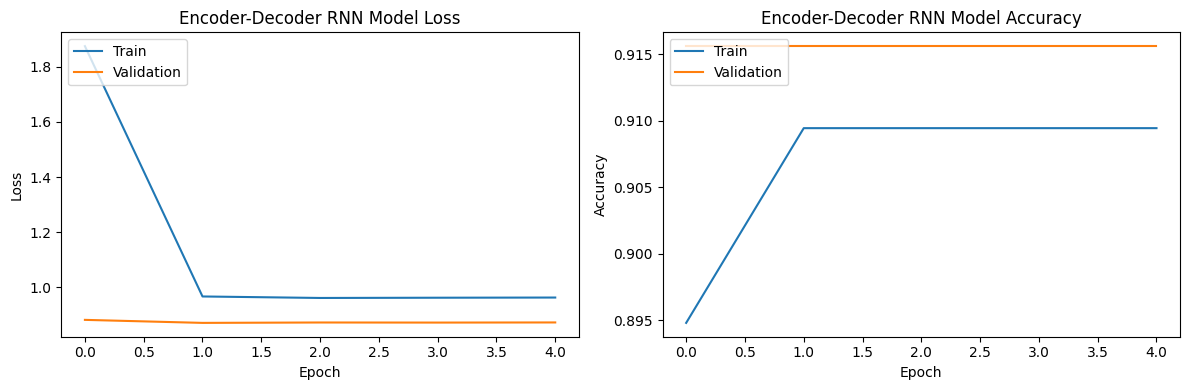

In [ ]:
# Plot training & validation loss values for Encoder-Decoder RNN Model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_encoder_decoder_rnn.history['loss'])
plt.plot(history_encoder_decoder_rnn.history['val_loss'])
plt.title('Encoder-Decoder RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values for Encoder-Decoder RNN Model
plt.subplot(1, 2, 2)
plt.plot(history_encoder_decoder_rnn.history['accuracy'])
plt.plot(history_encoder_decoder_rnn.history['val_accuracy'])
plt.title('Encoder-Decoder RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Load best Encoder-Decoder RNN model from checkpoint
best_enc_dec_rnn_model = load_model(enc_dec_rnn_checkpoint_path)

In [ ]:
test_loss, test_accuracy = best_enc_dec_rnn_model.evaluate(test_german_padded,test_english_padded_shifted)
print(" ")
print(f"Encoder-Decoder RNN Validation Loss: {test_loss:.2f}, Encoder-Decoder RNN Accuracy: {test_accuracy*100:.2f}")

63/63 [==============================] - 9s 133ms/step - loss: 0.8457 - accuracy: 0.9199
 
Encoder-Decoder RNN Validation Loss: 0.85, Encoder-Decoder RNN Accuracy: 91.99


In [ ]:
# Store accuracy in a dataframe
results_enc_dec_rnn_df = pd.DataFrame({'Model': ['Encoder-Decoder RNN'], 'Accuracy': [test_accuracy * 100]})
results_enc_dec_rnn_df

,Model,Accuracy
0,Encoder-Decoder RNN,91.985083


In [ ]:
import numpy as np
import random

# Define the new decode_sequence function
def decode_sequence(tokenizer, input_seq):
    """Decodes a sequence of token indices into a human-readable string."""
    decoded_sentence = ""
    for token_index in input_seq:
        if token_index == 0:  # Skip padding tokens
            continue
        word = tokenizer.index_word.get(token_index, '<unk>')
        decoded_sentence += word + " "
    return decoded_sentence.strip()

# Choose 5 random indices from the test set
random_indices = random.sample(range(len(test_german_padded)), 5)

# Select the random samples from the test data
X_sample = test_german_padded[random_indices]
y_sample = test_english_padded_shifted[random_indices]

# Define the prediction function
def predict_sequence(model, input_seq, max_len, tokenizer):
    """Predicts the output sequence using the model, given an input sequence."""
    target_seq = np.array([tokenizer.word_index.get('<start>', 0)]).reshape(1, 1)
    stop_condition = False
    decoded_sentence = ''

    for _ in range(max_len):
        # Pass only the input sequence to the predict method
        output_tokens = model.predict(input_seq)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer.index_word.get(sampled_token_index, '<unk>')

        if sampled_word == '<end>' or sampled_word == '<unk>':
            stop_condition = True

        if not stop_condition:
            decoded_sentence += ' ' + sampled_word

        target_seq = np.array([sampled_token_index]).reshape(1, 1)

    return decoded_sentence.strip()

# Decode actual and predicted sequences
sample_actual_decoded = [decode_sequence(english_tokenizer, seq) for seq in y_sample]
sample_pred_decoded = [predict_sequence(best_enc_dec_rnn_model, x.reshape(1, -1), max_len, english_tokenizer) for x in X_sample]

# Print actual and predicted sequences
for i in range(len(random_indices)):
    print(f"Example {i + 1}:")
    print(f"Actual English:   {sample_actual_decoded[i]}")
    print(f"Predicted English: {sample_pred_decoded[i]}\n")


1/1 [==============================] - 0s 140ms/step
Example 1:
Actual English:   supports all the s hardware out of the box with no configuration required and the configuration tools and applications have been to be friendly to the lower resolution screen
Predicted English: 

Example 2:
Actual English:   inspections were not eliminating that threat
Predicted English: 

Example 3:
Actual English:   once upon a time stocks were risky and securities were safe
Predicted English: 

Example 4:
Actual English:   free temporary mailbox a disposable need not be registered into the site will be randomly selected after a group of right addresses email address click custom address if you can select the name you want
Predicted English: 

Example 5:
Actual English:   have just spoken to him on the telephone which is why i am a couple of minutes late and have him on behalf of all you i hope i am allowed to do this and of course on behalf of his political friends from bavaria on reaching his th
Predi

##### Encoder - Decoder LSTM

We create an encoder-decoder LSTM model, with an embedding and bidirectional LSTM encoder, and an embedding, bidirectional LSTM decoder with attention, and then combines these components into a single model for sequence-to-sequence learning, compiling it with sparse categorical crossentropy loss and the Adam optimizer.

In [ ]:
embedding_dim = 128
# Define function to create encoder (shared for RNN and LSTM)
def create_encoder(vocab_size, embedding_dim, units):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
  model.add(Bidirectional(units(256, return_sequences=False)))  # Create an instance of SimpleRNN or LSTM
  model.add(Dense(max_len))
  return model

# Define function to create decoder with attention (shared for RNN and LSTM)
def create_decoder(english_vocab, embedding_dim, units):
  model = Sequential()
  model.add(Embedding(english_vocab, embedding_dim, input_length=max_len))
  model.add(Bidirectional(units(256, return_sequences=True)))
  model.add(Bidirectional(units(256)))
  model.add(RepeatVector(max_len))
  model.add(Dense(english_vocab, activation='softmax'))
  return model

  # Define function to create Encoder-Decoder LSTM model
def create_encoder_decoder_lstm_model(german_vocab, english_vocab, embedding_dim):
  encoder = create_encoder(german_vocab, embedding_dim, LSTM)
  decoder = create_decoder(english_vocab, embedding_dim, LSTM)

  # Combine encoder and decoder for training
  model = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
  model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
  # Print model summary
  model.summary()
  return model

encoder_decoder_lstm_model = create_encoder_decoder_lstm_model(german_vocab, english_vocab, embedding_dim)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14_input (InputL  [(None, 236)]             0         
 ayer)                                                           
                                                                 
 embedding_14 (Embedding)    (None, 236, 128)          3595648   
                                                                 
 bidirectional_13 (Bidirect  (None, 512)               788480    
 ional)                                                          
                                                                 
 dense_19 (Dense)            (None, 236)               121068    
                                                                 
 sequential_20 (Sequential)  (None, 236, 18185)        14019977  
                                                                 
Total params: 18525173 (70.67 MB)
Trainable params: 1852517

In [ ]:
# Define checkpoint path for Encoder-Decoder LSTM model
enc_dec_lstm_checkpoint_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints1/enc_dec_lstm_model_checkpoint.h5'
enc_dec_lstm_checkpoint = ModelCheckpoint(enc_dec_lstm_checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
# Train Encoder-Decoder LSTM model
# Train Encoder-Decoder RNN model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
# Train Encoder-Decoder LSTM model
history_encoder_decoder_lstm = encoder_decoder_lstm_model.fit(
  train_german_padded,
  train_english_padded,
  epochs=10,
  batch_size=64,
  validation_data=(test_german_padded, test_english_padded),
  callbacks=[enc_dec_lstm_checkpoint, early_stopping]
)

Epoch 1/10


125/125 [==============================] - ETA: 0s - loss: 1.5219 - accuracy: 0.9021
Epoch 1: val_accuracy improved from -inf to 0.91563, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/checkpoints1/enc_dec_lstm_model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 27s 159ms/step - loss: 1.5219 - accuracy: 0.9021 - val_loss: 0.8740 - val_accuracy: 0.9156
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 0.9701 - accuracy: 0.9095
Epoch 2: val_accuracy did not improve from 0.91563
125/125 [==============================] - 17s 136ms/step - loss: 0.9701 - accuracy: 0.9095 - val_loss: 0.8777 - val_accuracy: 0.9156
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.9713 - accuracy: 0.9095
Epoch 3: val_accuracy did not improve from 0.91563
125/125 [==============================] - 17s 136ms/step - loss: 0.9713 - accuracy: 0.9095 - val_loss: 0.8771 - val_accuracy: 0.9156
Epoch 4/10
125/125 [==============================] - ETA: 0s - loss: 0.9720 - accuracy: 0.9095
Epoch 4: val_accuracy did not improve from 0.91563
125/125 [==============================] - 17s 136ms/step - loss: 0.9720 - accuracy: 0.9095 - val_loss: 0.8780 - val_accuracy: 0.9156
Epoch 4: early stopping

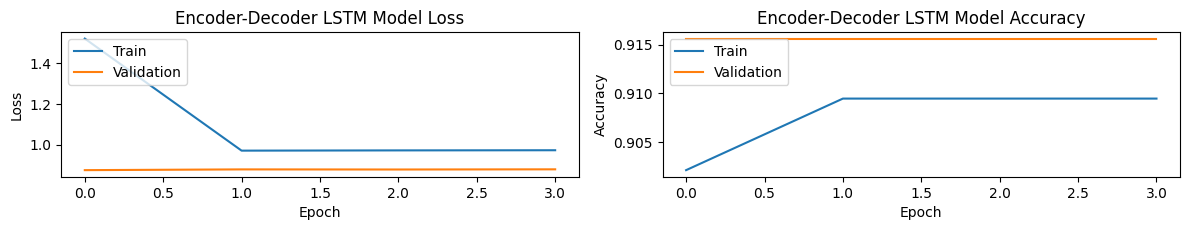

In [ ]:
# Plot training & validation loss values for Encoder-Decoder LSTM Model
plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(history_encoder_decoder_lstm.history['loss'])
plt.plot(history_encoder_decoder_lstm.history['val_loss'])
plt.title('Encoder-Decoder LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values for Encoder-Decoder LSTM Model
plt.subplot(2, 2, 2)
plt.plot(history_encoder_decoder_lstm.history['accuracy'])
plt.plot(history_encoder_decoder_lstm.history['val_accuracy'])
plt.title('Encoder-Decoder LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Load best Encoder-Decoder LSTM model from checkpoint
best_enc_dec_lstm_model = load_model(enc_dec_lstm_checkpoint_path)

In [ ]:
test_loss, test_accuracy = best_enc_dec_lstm_model.evaluate(test_german_padded,test_english_padded_shifted)
print(" ")
print(f"Encoder-Decoder LSTM Validation Loss: {test_loss:.2f}, Encoder-Decoder LSTM Accuracy: {test_accuracy*100:.2f}")

63/63 [==============================] - 5s 49ms/step - loss: 0.8380 - accuracy: 0.9199
 
Encoder-Decoder LSTM Validation Loss: 0.84, Encoder-Decoder LSTM Accuracy: 91.99


In [ ]:
# Store accuracy in a dataframe
results_enc_dec_lstm_df = pd.DataFrame({'Model': ['Encoder-Decoder LSTM'], 'Accuracy': [test_accuracy * 100]})
results_enc_dec_lstm_df

,Model,Accuracy
0,Encoder-Decoder LSTM,91.985083


In [ ]:
import numpy as np
import random

# Define the new decode_sequence function
def decode_sequence(tokenizer, input_seq):
    """Decodes a sequence of token indices into a human-readable string."""
    decoded_sentence = ""
    for token_index in input_seq:
        if token_index == 0:  # Skip padding tokens
            continue
        word = tokenizer.index_word.get(token_index, '<unk>')
        decoded_sentence += word + " "
    return decoded_sentence.strip()

# Choose 5 random indices from the test set
random_indices = random.sample(range(len(test_german_padded)), 5)

# Select the random samples from the test data
X_sample = test_german_padded[random_indices]
y_sample = test_english_padded_shifted[random_indices]

# Define the prediction function
def predict_sequence(model, input_seq, max_len, tokenizer):
    """Predicts the output sequence using the model, given an input sequence."""
    target_seq = np.array([tokenizer.word_index.get('<start>', 0)]).reshape(1, 1)
    stop_condition = False
    decoded_sentence = ''

    for _ in range(max_len):
        # Pass only the input sequence to the predict method
        output_tokens = model.predict(input_seq)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer.index_word.get(sampled_token_index, '<unk>')

        if sampled_word == '<end>' or sampled_word == '<unk>':
            stop_condition = True

        if not stop_condition:
            decoded_sentence += ' ' + sampled_word

        target_seq = np.array([sampled_token_index]).reshape(1, 1)

    return decoded_sentence.strip()

# Decode actual and predicted sequences
sample_actual_decoded = [decode_sequence(english_tokenizer, seq) for seq in y_sample]
sample_pred_decoded = [predict_sequence(best_enc_dec_lstm_model, x.reshape(1, -1), max_len, english_tokenizer) for x in X_sample]

# Print actual and predicted sequences
for i in range(len(random_indices)):
    print(f"Example {i + 1}:")
    print(f"Actual English:   {sample_actual_decoded[i]}")
    print(f"Predicted English: {sample_pred_decoded[i]}\n")

1/1 [==============================] - 0s 38ms/step
Example 1:
Actual English:   cold water the muscle prevents the and in the lower and tired legs
Predicted English: 

Example 2:
Actual English:   islands of and are dutyfree zones
Predicted English: 

Example 3:
Actual English:   after all are usually the forces suppressing their demands
Predicted English: 

Example 4:
Actual English:   conviction is a settled belief that brooks no argument
Predicted English: 

Example 5:
Actual English:   current used in most operations is shown in the area of the
Predicted English: 



##### Combined results from all models

In [ ]:
# Combine all results dataframes
combined_results_df = pd.concat([results_df, lstm_results_df, results_rnn_emb_df, results_lstm_emb_df, results_bi_rnn_emb_df, results_bi_lstm_emb_df, results_enc_dec_rnn_df, results_enc_dec_lstm_df], ignore_index=True)

# Display combined results dataframe
combined_results_df

,Model,Accuracy
0,RNN,91.987211
1,LSTM,92.062896
2,RNN with Embeddings,92.020375
3,LSTM with Embeddings,92.072892
4,Bidirectional RNN,92.070550
5,Bidirectional LSTM,91.985720
6,Encoder-Decoder RNN,91.985083
7,Encoder-Decoder LSTM,91.985083


##### INSIGHTS:
* **Highest Accuracy:** The LSTM with Embeddings achieved the highest accuracy at 92.072892%, closely followed by the Bidirectional RNN at 92.070550%.

* **Consistent Performance:** Most models, including Encoder-Decoder architectures and RNN variations, exhibit similar accuracy levels around 91.98% to 92.07%, indicating minimal improvement with different architectures or embeddings.

* **Repetitive Predictions:** Despite the high accuracy, the prediction quality is poor across all models, characterized by repetitive words in the generated sequences.

#### Trying other models with complex architechture


---



Despite good accuracy, our model struggles with good predictions. SO we will try more complex architechtures as well as train our model with shorter sentences to iprove prediction quality.

##### Model 1

###### We will now train the model with sentences upto 20 words. Also we use a more complex model.

The model consists of 13 layers, incorporating input layers, embedding layers for both source and target sequences, bidirectional RNN layers (likely LSTM or GRU) to process these embeddings, and an LSTM layer to handle sequence information. It includes attention mechanisms to align the target sequence with the source sequence and concatenates context vectors with LSTM outputs before producing the final predictions. The output layer is a TimeDistributed dense layer, predicting probabilities over a large vocabulary, with a total of 57,943,153 trainable parameters.

In [ ]:
def preprocess_df(df, max_length):
    # Add columns for the number of words in each sentence
    df['German_Word_Count'] = df['German'].apply(lambda x: len(x.split()))
    df['English_Word_Count'] = df['English'].apply(lambda x: len(x.split()))

    # Filter sentences with word lengths less than or equal to max_length
    df = df[(df['German_Word_Count'] <= max_length) & (df['English_Word_Count'] <= max_length)]

    # Check for duplicates
    duplicates = df.duplicated()
    print(f"Number of duplicate rows: {duplicates.sum()}")

    # Remove duplicates
    df = df.drop_duplicates()
    return df

In [ ]:
def clean_text(text):
    # Remove punctuations and special characters
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\n', '', text)
    return text

In [ ]:
def load_dataset(de_path, en_path):
    with open(de_path, 'r', encoding='utf-8') as de_file, open(en_path, 'r', encoding='utf-8') as en_file:
        de_sentences = de_file.readlines()
        en_sentences = en_file.readlines()

        # Handle length mismatch
        min_length = min(len(de_sentences), len(en_sentences))
        de_sentences = de_sentences[:min_length]
        en_sentences = en_sentences[:min_length]

    return pd.DataFrame({'German': de_sentences, 'English': en_sentences})

In [ ]:
training_dir = '/content/drive/MyDrive/Colab Notebooks/NLP/Language dataset/'

# Define the paths to the datasets
europarl_de = os.path.join(training_dir, 'europarl-v7.de-en.de')
europarl_en = os.path.join(training_dir, 'europarl-v7.de-en.en')
commoncrawl_de = os.path.join(training_dir, 'commoncrawl.de-en.de')
commoncrawl_en = os.path.join(training_dir, 'commoncrawl.de-en.en')
newscommentary_de = os.path.join(training_dir, 'news-commentary-v9.de-en.de')
newscommentary_en = os.path.join(training_dir, 'news-commentary-v9.de-en.en')

# Define the maximum word length
max_word_length = 18

# Load and preprocess the Europarl datasets
europarl_df = load_dataset(europarl_de, europarl_en)
print("Europarl dataset shape:", europarl_df.shape)

europarl_df = preprocess_df(europarl_df, max_word_length)

# Display the shape of the Europarl dataset
print("Europarl dataset shape with short sentences:", europarl_df.shape)

# Load and preprocess the Common Crawl datasets
commoncrawl_df = load_dataset(commoncrawl_de, commoncrawl_en)
print("Common Crawl dataset:", commoncrawl_df.shape)

commoncrawl_df = preprocess_df(commoncrawl_df, max_word_length)

# Display the shape of the Common Crawl dataset
print("Common Crawl dataset shape with short sentences:", commoncrawl_df.shape)

# Load and preprocess the News Commentary datasets
newscommentary_df = load_dataset(newscommentary_de, newscommentary_en)
print("News Commentary dataset shape:", newscommentary_df.shape)

newscommentary_df = preprocess_df(newscommentary_df, max_word_length)

# Display the shape of the News Commentary dataset
print("News Commentary dataset shape with short sentences:", newscommentary_df.shape)
print(" ----------- ---------- ---------- -------------")

# Select 20000 samples from each dataset randomly
europarl_sampled = europarl_df.sample(n=10000, random_state=42)
commoncrawl_sampled = commoncrawl_df.sample(n=10000, random_state=42)
newscommentary_sampled = newscommentary_df.sample(n=10000, random_state=42)

# Merge the datasets
combined_df = pd.concat([europarl_sampled, commoncrawl_sampled, newscommentary_sampled], ignore_index=True)

# Clean the text
combined_df['German'] = combined_df['German'].apply(clean_text)
combined_df['English'] = combined_df['English'].apply(clean_text)

# Add <start> and <end> tokens
combined_df['German'] = combined_df['German'].apply(lambda x: '<start> ' + x.strip() + ' <end>')
combined_df['English'] = combined_df['English'].apply(lambda x: '<start> ' + x.strip() + ' <end>')

# Display the first few rows of the combined dataset
print("")
print(combined_df.head())
print("\n")

# Tokenization and padding
def tokenize_and_pad(sentences, max_words=10000, max_len=20):
    tokenizer = Tokenizer(num_words=max_words, filters='', lower=False)
    tokenizer.fit_on_texts(sentences)
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_len)
    return padded_sequences, tokenizer

# Extract German and English sentences
german_sentences = combined_df['German'].values
english_sentences = combined_df['English'].values

# Tokenize and pad sentences
german_sequences, german_tokenizer = tokenize_and_pad(german_sentences, max_len=20)
english_sequences, english_tokenizer = tokenize_and_pad(english_sentences, max_len=20)

# Vocabulary sizes
german_vocab_size = len(german_tokenizer.word_index) + 1
english_vocab_size = len(english_tokenizer.word_index) + 1

print("German Vocabulary Size:", german_vocab_size)
print("English Vocabulary Size:", english_vocab_size)
print(" ----------- ---------- ---------- -------------")
print("German sequences shape:", german_sequences.shape)
print("English sequences shape:", english_sequences.shape)

Europarl dataset shape: (1920209, 2)
Number of duplicate rows: 43365
Europarl dataset shape with short sentences: (644842, 4)
Common Crawl dataset: (2399123, 2)
Number of duplicate rows: 0
Common Crawl dataset shape with short sentences: (1025919, 4)
News Commentary dataset shape: (201854, 2)
Number of duplicate rows: 51
News Commentary dataset shape with short sentences: (40464, 4)
 ----------- ---------- ---------- -------------

                                              German  \
0  <start> Im Grunde genommen wird dieser neue St...   
1  <start> Es gibt groe Herausforderungen und Mög...   
2  <start> Es geht jetzt um die Glaubwürdigkeit d...   
3  <start> Die Präsidentschaft wird sich für eine...   
4  <start> Ich hoffe sehr dass sich die große Meh...   

                                             English  German_Word_Count  \
0  <start> Essentially this new state will have t...                 13   
1  <start> The challenges and possibilities for u...                  9   
2 

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(german_sequences, english_sequences, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (24000, 20)
Test set size: (6000, 20)


In [ ]:
# Hyperparameters
german_max_len = 20  # Replace with actual maximum sequence length for German sentences
english_max_len = 20  # Replace with actual maximum sequence length for English sentences

# Split data into training and testing sets
# Replace with actual data splitting code
X_train, X_test, y_train, y_test = train_test_split(german_sequences, english_sequences, test_size=0.2, random_state=42)

# Reshape y_train and y_test for teacher forcing
y_train_reshaped = y_train[:, :-1] # Remove the last token from each sequence
y_test_reshaped = y_test[:, :-1]   # Remove the last token from each sequence

In [ ]:
# Encoder
encoder_inputs = Input(shape=(german_max_len,))
encoder_embed = Embedding(input_dim=german_vocab_size, output_dim=256)(encoder_inputs)
encoder_lstm1 = Bidirectional(LSTM(64, return_sequences=True))(encoder_embed)
encoder_lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(
    LSTM(256, return_state=True, return_sequences=True, dropout=0.3), merge_mode='concat')(encoder_lstm1)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

In [ ]:
# Decoder
decoder_inputs = Input(shape=(english_max_len - 1,)) # Input shape adjusted for teacher forcing
decoder_embed = Embedding(input_dim=english_vocab_size, output_dim=256)(decoder_inputs)
decoder_lstm1 = Bidirectional(LSTM(64, return_sequences=True))(decoder_embed)
decoder_lstm, _, _ = LSTM(512, return_sequences=True, return_state=True, dropout=0.3)(decoder_lstm1, initial_state=[state_h, state_c])

In [ ]:
# Luong Attention mechanism
attention = Dot(axes=[2, 2])([decoder_lstm, encoder_lstm])
attention = Activation('softmax')(attention)
context = Dot(axes=[2, 1])([attention, encoder_lstm])
decoder_combined_context = Concatenate(axis=-1)([context, decoder_lstm])

# Dense layer
decoder_outputs = TimeDistributed(Dense(english_vocab_size, activation='softmax'))(decoder_combined_context)

# Define the full model
seq2seq_attention_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
seq2seq_attention_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
seq2seq_attention_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 20)]                 0         []                            
                                                                                                  
 embedding_11 (Embedding)    (None, 20, 256)              1273676   ['input_12[0][0]']            
                                                          8                                       
                                                                                                  
 input_13 (InputLayer)       [(None, 19)]                 0         []                            
                                                                                                  
 bidirectional_13 (Bidirect  (None, 20, 128)              164352    ['embedding_11[0][0]']  

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = seq2seq_attention_model.fit(
    [X_train, y_train_reshaped],
    np.expand_dims(y_train[:, 1:], -1), # Target sequences shifted by one timestep
    epochs=10, batch_size=64,
    validation_data=([X_test, y_test_reshaped], np.expand_dims(y_test[:, 1:], -1)), # Validation data also shifted
    callbacks=[early_stopping]
)

Epoch 1/10
375/375 [==============================] - 90s 206ms/step - loss: 4.1679 - accuracy: 0.4555 - val_loss: 3.8133 - val_accuracy: 0.4757
Epoch 2/10
375/375 [==============================] - 68s 181ms/step - loss: 3.3053 - accuracy: 0.5258 - val_loss: 2.7769 - val_accuracy: 0.5961
Epoch 3/10
375/375 [==============================] - 67s 179ms/step - loss: 2.2626 - accuracy: 0.6526 - val_loss: 1.8173 - val_accuracy: 0.7200
Epoch 4/10
375/375 [==============================] - 71s 189ms/step - loss: 1.4937 - accuracy: 0.7474 - val_loss: 1.2613 - val_accuracy: 0.8012
Epoch 5/10
375/375 [==============================] - 71s 190ms/step - loss: 1.0053 - accuracy: 0.8148 - val_loss: 0.9286 - val_accuracy: 0.8476
Epoch 6/10
375/375 [==============================] - 71s 190ms/step - loss: 0.6877 - accuracy: 0.8640 - val_loss: 0.7240 - val_accuracy: 0.8798
Epoch 7/10
375/375 [==============================] - 71s 190ms/step - loss: 0.4663 - accuracy: 0.9056 - val_loss: 0.5966 - val_ac

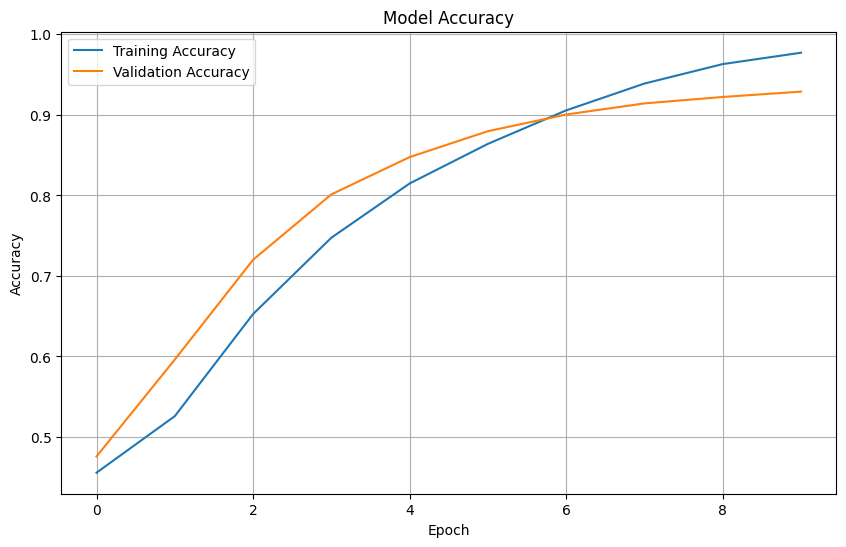

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate Seq2Seq Attention model on test data
# Provide both encoder and decoder inputs for evaluation
scores = seq2seq_attention_model.evaluate([X_test, y_test_reshaped], np.expand_dims(y_test[:, 1:], -1), verbose=0)
print("Seq2Seq Attention Model Test Accuracy:", scores[1])

# Store accuracy in a dataframe
results_df = pd.DataFrame({'Model': ['Seq2Seq Attention'], 'Accuracy': [scores[1] * 100]})
print(results_df)

# Choose 5 random indices from test set
random_indices = random.sample(range(len(X_test)), 5)

# Select the random samples from X_test
X_sample = X_test[random_indices]
y_sample = y_test[random_indices]

# Decode sequences from indices to words using tokenizer
def decode_sequence(tokenizer, sequence):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    decoded_sentence = ' '.join(reverse_word_map.get(token, '<unk>') for token in sequence if token != 0)
    return decoded_sentence


Seq2Seq Attention Model Test Accuracy: 0.9289122819900513
               Model   Accuracy
0  Seq2Seq Attention  92.891228


In [ ]:
# Prepare decoder input sequences for prediction
decoder_input_sample = np.zeros((len(X_sample), 1))

# Function to predict using the Seq2Seq Attention model with greedy search
def predict_sequence(model, input_seq, max_len, tokenizer):
    # Start with the <start> token
    target_seq = np.array([tokenizer.word_index['<start>']] * len(input_seq)).reshape(-1, 1)
    stop_condition = False
    decoded_sentence = ''

    for _ in range(max_len):
        # Only unpack the output tokens
        output_tokens = model.predict([input_seq, target_seq])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[:, -1, :], axis=-1)
        sampled_word = tokenizer.index_word.get(sampled_token_index[0], '<unk>')

        if sampled_word == '<end>' or sampled_word == '<unk>':
            stop_condition = True

        if not stop_condition:
            decoded_sentence += ' ' + sampled_word

            # Update the target sequence
            target_seq = np.hstack([target_seq, sampled_token_index.reshape(-1, 1)])

    return decoded_sentence.strip()

# Decode actual and predicted sequences
sample_pred_decoded = [predict_sequence(seq2seq_attention_model, x.reshape(1, -1), english_max_len, english_tokenizer) for x in X_sample]
sample_actual_decoded = [decode_sequence(english_tokenizer, seq) for seq in y_sample[:, 1:]]
gernam_sentence = [decode_sequence(german_tokenizer, seq) for seq in X_sample]

# Print actual and predicted sequences
for i in range(len(random_indices)):
    print(f"Example {i + 1}:")
    print(f"German Sentence: {gernam_sentence[i]}\n")
    print(f"Actual English: {sample_actual_decoded[i]}")
    print(f"Predicted English: {sample_pred_decoded[i]}\n")

1/1 [==============================] - 0s 21ms/step
Example 1:
German Sentence: <start> Außerdem haben wir es auch mit der sehr wichtigen Frage der Datensicherheit zu tun <end>

Actual English: In addition we are also dealing with the very important question of data security <end>
Predicted English: Technological sticking precaution immigration immigration immigration immigration threatens hate immigration immigration hate

Example 2:
German Sentence: <start> Ich würde gern wissen ob das so ist <end>

Actual English: I would like to know whether this is the case <end>
Predicted English: Lastly Rühle Ms understands unto Ms excessively pursued pursued pursued pursued pursued pursued pursued

Example 3:
German Sentence: <start> In diesen stecken über Jahre Erfahrung im und auf den Straßen der Welt <end>

Actual English: These are the of years of experience in motor racing and on the open road <end>
Predicted English: Fixed cafe Monte breaks pushed educated educated cm inhouse inhouse inho

###### Insights
We see a significant improvement in accuracy upto 92.89%. We also see improvement in precition qualty with the predictions being non-repetitive. However the predictions are still inconsistent with actual predictions.

##### Model 2

###### We now use more smaller sentences for training by taking the sentences of word length upto 5.

We train a GRU model, which is a sequence-to-sequence model using GRU-based architecture with bidirectional processing. The encoder employs a GRU layer followed by batch normalization, and the decoder includes another GRU layer with attention mechanisms computed via dot products. The final output is produced through a TimeDistributed dense layer with a vocabulary size of 11,097, resulting in a total of 15,358,197 parameters.

In [ ]:
import os
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the path to the training directory
training_dir = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training'

# Define the paths to the datasets
europarl_de = os.path.join(training_dir, 'europarl-v7.de-en.de')
europarl_en = os.path.join(training_dir, 'europarl-v7.de-en.en')
commoncrawl_de = os.path.join(training_dir, 'commoncrawl.de-en.de')
commoncrawl_en = os.path.join(training_dir, 'commoncrawl.de-en.en')
newscommentary_de = os.path.join(training_dir, 'news-commentary-v9.de-en.de')
newscommentary_en = os.path.join(training_dir, 'news-commentary-v9.de-en.de')

def load_dataset(de_path, en_path):
    with open(de_path, 'r', encoding='utf-8') as de_file, open(en_path, 'r', encoding='utf-8') as en_file:
        de_sentences = de_file.readlines()
        en_sentences = en_file.readlines()

    return pd.DataFrame({'German': de_sentences, 'English': en_sentences})

def preprocess_df(df, max_length):
    # Add columns for the number of words in each sentence
    df['German_Word_Count'] = df['German'].apply(lambda x: len(x.split()))
    df['English_Word_Count'] = df['English'].apply(lambda x: len(x.split()))

    # Filter sentences with word lengths less than or equal to max_length
    df = df[(df['German_Word_Count'] <= max_length) & (df['English_Word_Count'] <= max_length)]

    # Check for duplicates
    duplicates = df.duplicated()
    print(f"Number of duplicate rows: {duplicates.sum()}")

    # Remove duplicates
    df = df.drop_duplicates()
    return df

def clean_text(text):
    # Remove punctuations and special characters
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\n', '', text)
    return text

# Define the maximum word length
max_word_length = 5

# Load and preprocess the Europarl datasets
europarl_df = load_dataset(europarl_de, europarl_en)
print("Europarl dataset shape:", europarl_df.shape)

europarl_df = preprocess_df(europarl_df, max_word_length)

# Display the shape of the Europarl dataset
print("Europarl dataset shape with short sentences:", europarl_df.shape)

# Load and preprocess the Common Crawl datasets
commoncrawl_df = load_dataset(commoncrawl_de, commoncrawl_en)
print("Common Crawl dataset:", commoncrawl_df.shape)

commoncrawl_df = preprocess_df(commoncrawl_df, max_word_length)

# Display the shape of the Common Crawl dataset
print("Common Crawl dataset shape with short sentences:", commoncrawl_df.shape)

# Load and preprocess the Common Crawl datasets
newscommentary_df = load_dataset(newscommentary_de, newscommentary_en)
print("Common Crawl dataset:", newscommentary_df.shape)

newscommentary_df = preprocess_df(newscommentary_df, max_word_length)

# Display the shape of the Common Crawl dataset
print("Common Crawl dataset shape with short sentences:", newscommentary_df.shape)

Europarl dataset shape: (1920209, 2)
Number of duplicate rows: 30118
Europarl dataset shape with short sentences: (33478, 4)
Common Crawl dataset: (2399123, 2)
Number of duplicate rows: 0
Common Crawl dataset shape with short sentences: (0, 4)
Common Crawl dataset: (201854, 2)
Number of duplicate rows: 684
Common Crawl dataset shape with short sentences: (8317, 4)


In [ ]:
combined_df = europarl_df
#combined_df = europarl_df

# Clean the text
combined_df['German'] = combined_df['German'].apply(clean_text)
combined_df['English'] = combined_df['English'].apply(clean_text)

print(combined_df.shape)

(33478, 4)


In [ ]:
from collections import Counter
import pandas as pd

# Tokenize the sentences
combined_df['German_Tokens'] = combined_df['German'].apply(lambda x: x.split())
combined_df['English_Tokens'] = combined_df['English'].apply(lambda x: x.split())

# Count word frequencies
german_word_counts = Counter([word for sentence in combined_df['German_Tokens'] for word in sentence])
english_word_counts = Counter([word for sentence in combined_df['English_Tokens'] for word in sentence])

# Create DataFrames from the word counts
german_freq_df = pd.DataFrame(german_word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).reset_index(drop=True)
english_freq_df = pd.DataFrame(english_word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).reset_index(drop=True)

In [ ]:
# Display the first few rows of the frequency DataFrames
german_freq_df.head(20)

,Word,Frequency
0,ist,5914
1,Das,4925
2,nicht,2146
3,Wir,1741
4,das,1719
5,Bericht,1578
6,Herr,1558
7,Ich,1529
8,Sie,1527
9,die,1464


In [ ]:
# Count words with frequency 1
german_count_freq_one = german_freq_df[german_freq_df['Frequency'] != 1].shape[0]

print("Number of words not with frequency 1:", german_count_freq_one)

Number of words not with frequency 1: 6312


In [ ]:
english_freq_df.head(20)

,Word,Frequency
0,is,7336
1,That,2777
2,the,2526
3,We,2218
4,This,2155
5,I,2111
6,are,2028
7,not,1912
8,you,1816
9,The,1612


In [ ]:
# Count words with frequency 1
english_count_freq_one = english_freq_df[english_freq_df['Frequency'] != 1].shape[0]

print("Number of words not with frequency 1:", english_count_freq_one)

Number of words not with frequency 1: 5747


In [ ]:
# Add <start> and <end> tokens
combined_df['German'] = combined_df['German'].apply(lambda x: '<start> ' + x.strip() + ' <end>')
combined_df['English'] = combined_df['English'].apply(lambda x: '<start> ' + x.strip() + ' <end>')

# Display the first few rows of the combined dataset
combined_df.head()

,German,English,German_Word_Count,English_Word_Count,German_Tokens,English_Tokens
0,<start> Wiederaufnahme der Sitzungsperiode <end>,<start> Resumption of the session <end>,3,4,"[Wiederaufnahme, der, Sitzungsperiode]","[Resumption, of, the, session]"
21,<start> Frau Präsidentin <end>,<start> <end>,2,0,"[Frau, Präsidentin]",[]
67,<start> Arbeitsplan <end>,<start> Agenda <end>,1,1,[Arbeitsplan],[Agenda]
70,<start> Zum Mittwoch <end>,<start> Relating to Wednesday <end>,2,3,"[Zum, Mittwoch]","[Relating, to, Wednesday]"
86,<start> Beifall der PSEFraktion <end>,<start> Applause from the PSE Group <end>,3,5,"[Beifall, der, PSEFraktion]","[Applause, from, the, PSE, Group]"


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def tokenize_and_pad(sentences, max_words, max_len=7):
    # Initialize Tokenizer with the number of words to keep
    tokenizer = Tokenizer(num_words=max_words, filters='', lower=False, oov_token='<OOV>')

    # Fit the tokenizer on the provided sentences
    tokenizer.fit_on_texts(sentences)

    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(sentences)

    # Pad sequences to ensure consistent length
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_len)

    return padded_sequences, tokenizer

# Extract German and English sentences
german_sentences = combined_df['German'].values
english_sentences = combined_df['English'].values

# Tokenize and pad sentences
german_sequences, german_tokenizer = tokenize_and_pad(german_sentences, max_words=6312, max_len=7)
english_sequences, english_tokenizer = tokenize_and_pad(english_sentences, max_words=5747, max_len=7)

# Vocabulary sizes
german_vocab_size = len(german_tokenizer.word_index) + 1  # +1 for the OOV token
english_vocab_size = len(english_tokenizer.word_index) + 1  # +1 for the OOV token

print("German Vocabulary Size:", german_vocab_size)
print("English Vocabulary Size:", english_vocab_size)
print("German sequences shape:", german_sequences.shape)
print("English sequences shape:", english_sequences.shape)

German Vocabulary Size: 14246
English Vocabulary Size: 11097
German sequences shape: (33478, 7)
English sequences shape: (33478, 7)


In [ ]:
combined_df.head()

,German,English,German_Word_Count,English_Word_Count,German_Tokens,English_Tokens
0,<start> Wiederaufnahme der Sitzungsperiode <end>,<start> Resumption of the session <end>,3,4,"[Wiederaufnahme, der, Sitzungsperiode]","[Resumption, of, the, session]"
21,<start> Frau Präsidentin <end>,<start> <end>,2,0,"[Frau, Präsidentin]",[]
67,<start> Arbeitsplan <end>,<start> Agenda <end>,1,1,[Arbeitsplan],[Agenda]
70,<start> Zum Mittwoch <end>,<start> Relating to Wednesday <end>,2,3,"[Zum, Mittwoch]","[Relating, to, Wednesday]"
86,<start> Beifall der PSEFraktion <end>,<start> Applause from the PSE Group <end>,3,5,"[Beifall, der, PSEFraktion]","[Applause, from, the, PSE, Group]"


In [ ]:
def find_max_length(sequences):
    # Find the maximum length of the sequences
    max_length = max(len(seq) for seq in sequences)
    return max_length

# Find maximum lengths
max_german_length = find_max_length(german_sequences)
max_english_length = find_max_length(english_sequences)

print("Maximum German Sentence Length:", max_german_length)
print("Maximum English Sentence Length:", max_english_length)

Maximum German Sentence Length: 7
Maximum English Sentence Length: 7


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(german_sequences, english_sequences, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (26782, 7)
Test set size: (6696, 7)


In [ ]:
X_train[0]

array([  2,  15,  55,  42, 276,   3,   0], dtype=int32)

In [ ]:
X_test[0]

array([  2,  28, 221,   8, 179, 868,   3], dtype=int32)

In [ ]:
y_train[0]

array([  2,  13,  48,   4, 121,   3,   0], dtype=int32)

In [ ]:
y_test[0]

array([  2,  22,  92,  18, 181,   3,   0], dtype=int32)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model # Added load_model import
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate, TimeDistributed, Bidirectional # Added Bidirectional import
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dot, Activation # Added Dot and Activation imports

In [ ]:
# Hyperparameters
german_max_len = 7  # Replace with actual maximum sequence length for German sentences
english_max_len = 7  # Replace with actual maximum sequence length for English sentences


# Define checkpoint path for Seq2Seq model
checkpoint_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/seq2seq_gru_new_model_checkpoint.h5'
checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

# Reshape y_train and y_test for teacher forcing
y_train_reshaped = y_train[:, :-1] # Remove the last token from each sequence
y_test_reshaped = y_test[:, :-1]   # Remove the last token from each sequence

In [ ]:
from tensorflow.keras.layers import Input, Embedding, GRU, BatchNormalization, Dense, Concatenate, Dot, Activation, TimeDistributed

In [ ]:
# Encoder
encoder_inputs = Input(shape=(german_max_len,))
encoder_embed = Embedding(input_dim=german_vocab_size, output_dim=300)(encoder_inputs)  # Using 300-dim embedding
encoder_gru, state_h = GRU(300, return_sequences=True, return_state=True, dropout=0.3)(encoder_embed)
encoder_batchnorm = BatchNormalization()(encoder_gru)

# Decoder
decoder_inputs = Input(shape=(english_max_len - 1,))
decoder_embed = Embedding(input_dim=english_vocab_size, output_dim=300)(decoder_inputs)  # Using 300-dim embedding
decoder_gru, _ = GRU(300, return_sequences=True, return_state=True, dropout=0.3)(decoder_embed, initial_state=state_h)
decoder_batchnorm = BatchNormalization()(decoder_gru)

# Luong Attention mechanism
attention = Dot(axes=[2, 2])([decoder_batchnorm, encoder_batchnorm])
attention = Activation('softmax')(attention)
context = Dot(axes=[2, 1])([attention, encoder_batchnorm])
decoder_combined_context = Concatenate(axis=-1)([context, decoder_batchnorm])

# Dense layer
decoder_outputs = TimeDistributed(Dense(english_vocab_size, activation='softmax'))(decoder_combined_context)

# Define the full model
seq2seq_attention_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
seq2seq_attention_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
seq2seq_attention_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 7)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 embedding_16 (Embedding)    (None, 7, 300)               4273800   ['input_1[0][0]']             
                                                                                                  
 embedding_17 (Embedding)    (None, 6, 300)               3329100   ['input_2[0][0]']             
                                                                                            

In [ ]:
# Train the model
history = seq2seq_attention_model.fit(
    [X_train, y_train_reshaped],
    np.expand_dims(y_train[:, 1:], -1), # Target sequences shifted by one timestep
    epochs=5, batch_size=120,
    validation_data=([X_test, y_test_reshaped], np.expand_dims(y_test[:, 1:], -1)), # Validation data also shifted
    callbacks=[checkpoint_callback]
)

Epoch 1/5
224/224 [==============================] - ETA: 0s - loss: 3.7385 - accuracy: 0.4716
Epoch 1: val_accuracy improved from -inf to 0.53101, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/seq2seq_gru_new_model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


224/224 [==============================] - 25s 79ms/step - loss: 3.7385 - accuracy: 0.4716 - val_loss: 7.1349 - val_accuracy: 0.5310
Epoch 2/5
224/224 [==============================] - ETA: 0s - loss: 2.3212 - accuracy: 0.6031
Epoch 2: val_accuracy improved from 0.53101 to 0.60240, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/seq2seq_gru_new_model_checkpoint.h5
224/224 [==============================] - 7s 31ms/step - loss: 2.3212 - accuracy: 0.6031 - val_loss: 3.3637 - val_accuracy: 0.6024
Epoch 3/5
224/224 [==============================] - ETA: 0s - loss: 1.7096 - accuracy: 0.6662
Epoch 3: val_accuracy improved from 0.60240 to 0.65046, saving model to /content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/seq2seq_gru_new_model_checkpoint.h5
224/224 [==============================] - 6s 26ms/step - loss: 1.7096 - accuracy: 0.6662 - val_loss: 2.0426 - 

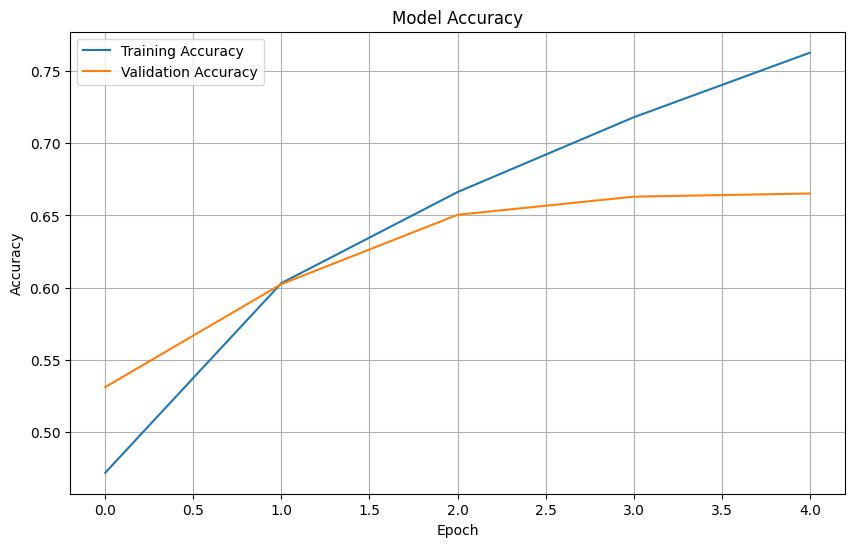

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
checkpoint_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/seq2seq_gru_new_model_checkpoint.h5'

# Load best Seq2Seq Attention model from checkpoint
best_model = load_model(checkpoint_path)

# Evaluate Seq2Seq Attention model on test data
# Provide both encoder and decoder inputs for evaluation
scores = best_model.evaluate([X_test, y_test_reshaped], np.expand_dims(y_test[:, 1:], -1), verbose=0)
print("Seq2Seq GRU Model Test Accuracy:", scores[1])

# Store accuracy in a dataframe
results_df = pd.DataFrame({'Model': ['Seq2Seq GRU'], 'Accuracy': [scores[1] * 100]})
print(results_df)

# Choose 5 random indices from test set
random_indices = random.sample(range(len(X_test)), 5)

# Select the random samples from X_test
X_sample = X_test[random_indices]
y_sample = y_test[random_indices]

Seq2Seq GRU Model Test Accuracy: 0.665247917175293
         Model   Accuracy
0  Seq2Seq GRU  66.524792


In [ ]:
def decode_sequence(tokenizer, input_seq):
    """Decodes a sequence of token indices into a human-readable string."""
    decoded_sentence = ""
    for token_index in input_seq:
        if token_index == 0:  # Skip padding tokens
            continue
        word = tokenizer.index_word.get(token_index, '<OOV>')
        decoded_sentence += word + " "
    return decoded_sentence.strip()

# Choose 25 random indices from test set
random_indices = random.sample(range(len(X_test)), 25)

# Select the random samples from X_test
X_sample = X_test[random_indices]
y_sample = y_test[random_indices]

# Prepare decoder input sequences for prediction
decoder_input_sample = np.zeros((len(X_sample), 1))

def predict_sequence(model, input_seq, max_len, tokenizer):
    # Start with the <start> token
    target_seq = np.array([tokenizer.word_index.get('<start>', 0)]).reshape(1, 1)
    stop_condition = False
    decoded_sentence = ''

    for _ in range(max_len):
        # Predict the next token
        output_tokens = model.predict([input_seq, target_seq])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer.index_word.get(sampled_token_index, '<OOV>')

        # Stop if <end> token is reached
        if sampled_word == '<end>' or sampled_word == '<OOV>':
            stop_condition = True

        if not stop_condition:
            decoded_sentence += ' ' + sampled_word

            # Update the target sequence
            target_seq = np.hstack([target_seq, np.array([[sampled_token_index]])])

    return decoded_sentence.strip()


# Decode actual and predicted sequences
sample_pred_decoded = [predict_sequence(best_model, x.reshape(1, -1), english_max_len, english_tokenizer) for x in X_sample]
sample_actual_decoded = [decode_sequence(english_tokenizer, seq) for seq in y_sample[:, 1:]] # Call the newly defined function

# Print actual and predicted sequences
for i in range(len(random_indices)):
    print(f"Example {i + 1}:")
    print(f"Actual English: {sample_actual_decoded[i]}")
    print(f"Predicted English: {sample_pred_decoded[i]}\n")

1/1 [==============================] - 0s 22ms/step
Example 1:
Actual English: We must be humble however <end>
Predicted English: We must however be however

Example 2:
Actual English: Subject Visa exemption for Macedonia <end>
Predicted English: Subject EU financial supervision

Example 3:
Actual English: This is a crucial measure <end>
Predicted English: That is a

Example 4:
Actual English: Is this delay justified <end>
Predicted English: Is this wise overall case

Example 5:
Actual English: We must go further <end>
Predicted English: There must be made

Example 6:
Actual English: What is to be done <end>
Predicted English: So what can we do

Example 7:
Actual English: First crossborder workers <end>
Predicted English: 

Example 8:
Actual English: Thirdly enlargement <end>
Predicted English: Enlargement enlargement

Example 9:
Actual English: The current economy is sick <end>
Predicted English: The scope is growing

Example 10:
Actual English: What can I do <end>
Predicted English: 

###### Insights:

The model sees a drop in accuracy to 66.52%.

But the predictions indicate that the model is able to predict the shorter sentences in the test data well, with several predictions aligning with the actual sentences. Also the predictions are meaningful in most of the cases indicating that the model is learning well.

So we use Model 2 as our final model

#### Testing final model to unseen data:

##### Let's see how the model performs on unseen data, to understand applicability of the model in real world.

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example German sentences (Replace these with actual sentences if needed)
german_sentences = [
    "Ich habe ein Buch",
    "Wie geht es dir",
    "Das Wetter ist schön",
    "Ich liebe die Musik",
    "Wo ist die Toilette",
    "Könnten Sie mir helfen",
    "Ich möchte einen Kaffee",
    "Haben Sie einen Tisch für zwei",
    "Wann beginnt der Film",
    "Ich gehe ins Kino"
]

# Corresponding actual English translations
english_sentences = [
    "I have a book",
    "How are you",
    "The weather is nice",
    "I love the music",
    "Where is the toilet",
    "Could you help me",
    "I want a coffee",
    "Do you have a table for two",
    "When does the movie start",
    "I am going to the cinema"
]

# Example German tokenizer (train this tokenizer on your German data)
german_tokenizer = Tokenizer(num_words=10000, filters='', lower=False)
german_tokenizer.fit_on_texts(german_sentences)  # This should be fit on the full German training data

# Convert sentences to sequences and pad them
def preprocess_sentences(sentences, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences

# Preprocess the German sentences
max_german_len = 5  # Assuming the max length you want for German sentences
X_new = preprocess_sentences(german_sentences, german_tokenizer, max_german_len)

# Prepare decoder input sequences (start with <start> token)
def prepare_decoder_input_sequences(num_samples, max_len, tokenizer):
    return np.array([[tokenizer.word_index.get('<start>', 0)]] * num_samples)

# Prepare decoder input sequences
decoder_input_sequences = prepare_decoder_input_sequences(len(german_sentences), max_german_len, german_tokenizer)

# Define the function to decode sequences (same as in your code)
def predict_sequence(model, input_seq, max_len, tokenizer):
    target_seq = np.array([tokenizer.word_index.get('<start>', 0)]).reshape(1, 1)
    stop_condition = False
    decoded_sentence = ''

    for _ in range(max_len):
        output_tokens = model.predict([input_seq, target_seq])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer.index_word.get(sampled_token_index, '<OOV>')

        if sampled_word == '<end>' or sampled_word == '<OOV>':
            stop_condition = True

        if not stop_condition:
            decoded_sentence += ' ' + sampled_word
            target_seq = np.hstack([target_seq, np.array([[sampled_token_index]])])

    return decoded_sentence.strip()

# Use the model to predict English sentences
sample_pred_decoded = [predict_sequence(best_model, x.reshape(1, -1), english_max_len, english_tokenizer) for x in X_new]

# Print the German sentences, their actual English translations, and the predicted English translations
for i, sentence in enumerate(german_sentences):
    print(f"German Sentence {i + 1}: {sentence}")
    print(f"Actual English: {english_sentences[i]}")
    print(f"Predicted English: {sample_pred_decoded[i]}\n")

1/1 [==============================] - 0s 23ms/step
German Sentence 1: Ich habe ein Buch
Actual English: I have a book
Predicted English: We have not begging

German Sentence 2: Wie geht es dir
Actual English: How are you
Predicted English: Thank you Mr Poos

German Sentence 3: Das Wetter ist schön
Actual English: The weather is nice
Predicted English: We have the result

German Sentence 4: Ich liebe die Musik
Actual English: I love the music
Predicted English: 

German Sentence 5: Wo ist die Toilette
Actual English: Where is the toilet
Predicted English: There are the draft

German Sentence 6: Könnten Sie mir helfen
Actual English: Could you help me
Predicted English: Thank you

German Sentence 7: Ich möchte einen Kaffee
Actual English: I want a coffee
Predicted English: Does that be a fact

German Sentence 8: Haben Sie einen Tisch für zwei
Actual English: Do you have a table for two
Predicted English: That is a fact

German Sentence 9: Wann beginnt der Film
Actual English: When does 

---
##### INSIGHTS

While the model predictions were decently accurate on test data, the predictions on unseen data were inaccurate suggesting that the model is performing poorly on unseen data. Though the predicted sentences were meaningful and non-repetitive, they were inconsistent with the actual sentences.

This suggests that the model's ability to handle real-world or novel contexts is limited and that it may not perform well outside the scope of the training data.


---


>>>> #### **Step 4:** Choose the best performing model and pickle it.

---



In [ ]:
import pickle

best_model_checkpoint_path = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/seq2seq_gru_new_model_checkpoint.h5'
best_model = load_model(best_model_checkpoint_path)

In [ ]:
from tensorflow.keras.models import load_model
best_model.save('/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/final_model_checkpoint.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Path to save the pickled model in Google Drive
pickle_path_drive = '/content/drive/My Drive/GREAT LEARNING MATERIALS/PGP AIML/Module 11: Capstone Project/NLP Project 2/training/final_model.pickle'

# Pickle the best model and save to Google Drive
pickle.dump(best_model, open(pickle_path_drive, 'wb'))

print(f"Best performing model has been pickled to Google Drive.")


Best performing model has been pickled to Google Drive.


#### SUGGESTIONS:


---



To enhance the model's performance on unseen data, consider the following strategies:

1. **Expand Training Data:** Collect more diverse and comprehensive training data to improve the model’s ability to generalize.
2. **Synthetic Data:** Use data augmentation techniques or generate synthetic examples to increase variability in the training set.
Regularization Techniques:
3. **Dropout:** Implement dropout layers to prevent overfitting and improve generalization.
4. **Weight Regularization:** Apply L1/L2 regularization to the weights to penalize large weights and reduce overfitting.
Model Architecture:
5.**Complex Models:** Experiment with more complex architectures or different types of layers (e.g., Transformers, deeper networks) that might better capture nuances in the data.
6. **Attention Mechanisms:** Incorporate advanced attention mechanisms or architectures designed to better handle long-range dependencies and context.
7. **Hyperparameter Tuning:** Optimize Hyperparameters: Perform hyperparameter optimization to find the best settings for learning rate, batch size, number of layers, etc.

>>>> **Step 5:** Final Report

---



[Report link](https://drive.google.com/file/d/186Exgd543SDCrP3NUeCAb4RnLpVEUJd0/view?usp=sharing)